# Imports

In [352]:
import neurokit as nk
import numpy as np
import pandas as pd

# Read data from files and clean it

In [353]:
fileName='./data/M/2019_07_03_MP_Dep_Run1.txt'

In [354]:
#Big endian to little endian conversion needed to read acq recorded on windows :/
#nk.read_acqknowledge('./data/M/2019_07_03_MP_Dep_Run1.acq')

In [355]:
#df, sampling_rate = nk.read_acqknowledge('./data/M/2019_07_03_MP_Dep_Run1.acq', return_sampling_rate=True)

In [356]:
df=pd.read_csv(fileName,header=[15])

In [357]:
sampling_rate = 1000

In [358]:
df.columns.values

array(['CH1', 'CH2', 'CH3', 'CH40', 'CH41', 'CH42', 'Unnamed: 6'],
      dtype=object)

In [359]:
df.head() #CH41 = RR intervals biopac

CH1            CH2            CH3           CH40      CH41  \
0  301595.000000  301595.000000  301595.000000  301595.000000  301595.0   
1      -0.926208      -0.147552       0.025635      -0.147529       0.0   
2      -0.926208      -0.136719       0.028687      -0.136746       0.0   
3      -0.927734      -0.126953       0.030518      -0.127189       0.0   
4      -0.929260      -0.118103       0.029907      -0.118689       0.0   

       CH42  Unnamed: 6  
0  301595.0         NaN  
1       0.0         NaN  
2       0.0         NaN  
3       0.0         NaN  
4       0.0         NaN

In [360]:
ecg_data = df[['CH3']]
rr_intervals = df[['CH41']]

In [361]:
type(ecg_data)

pandas.core.frame.DataFrame

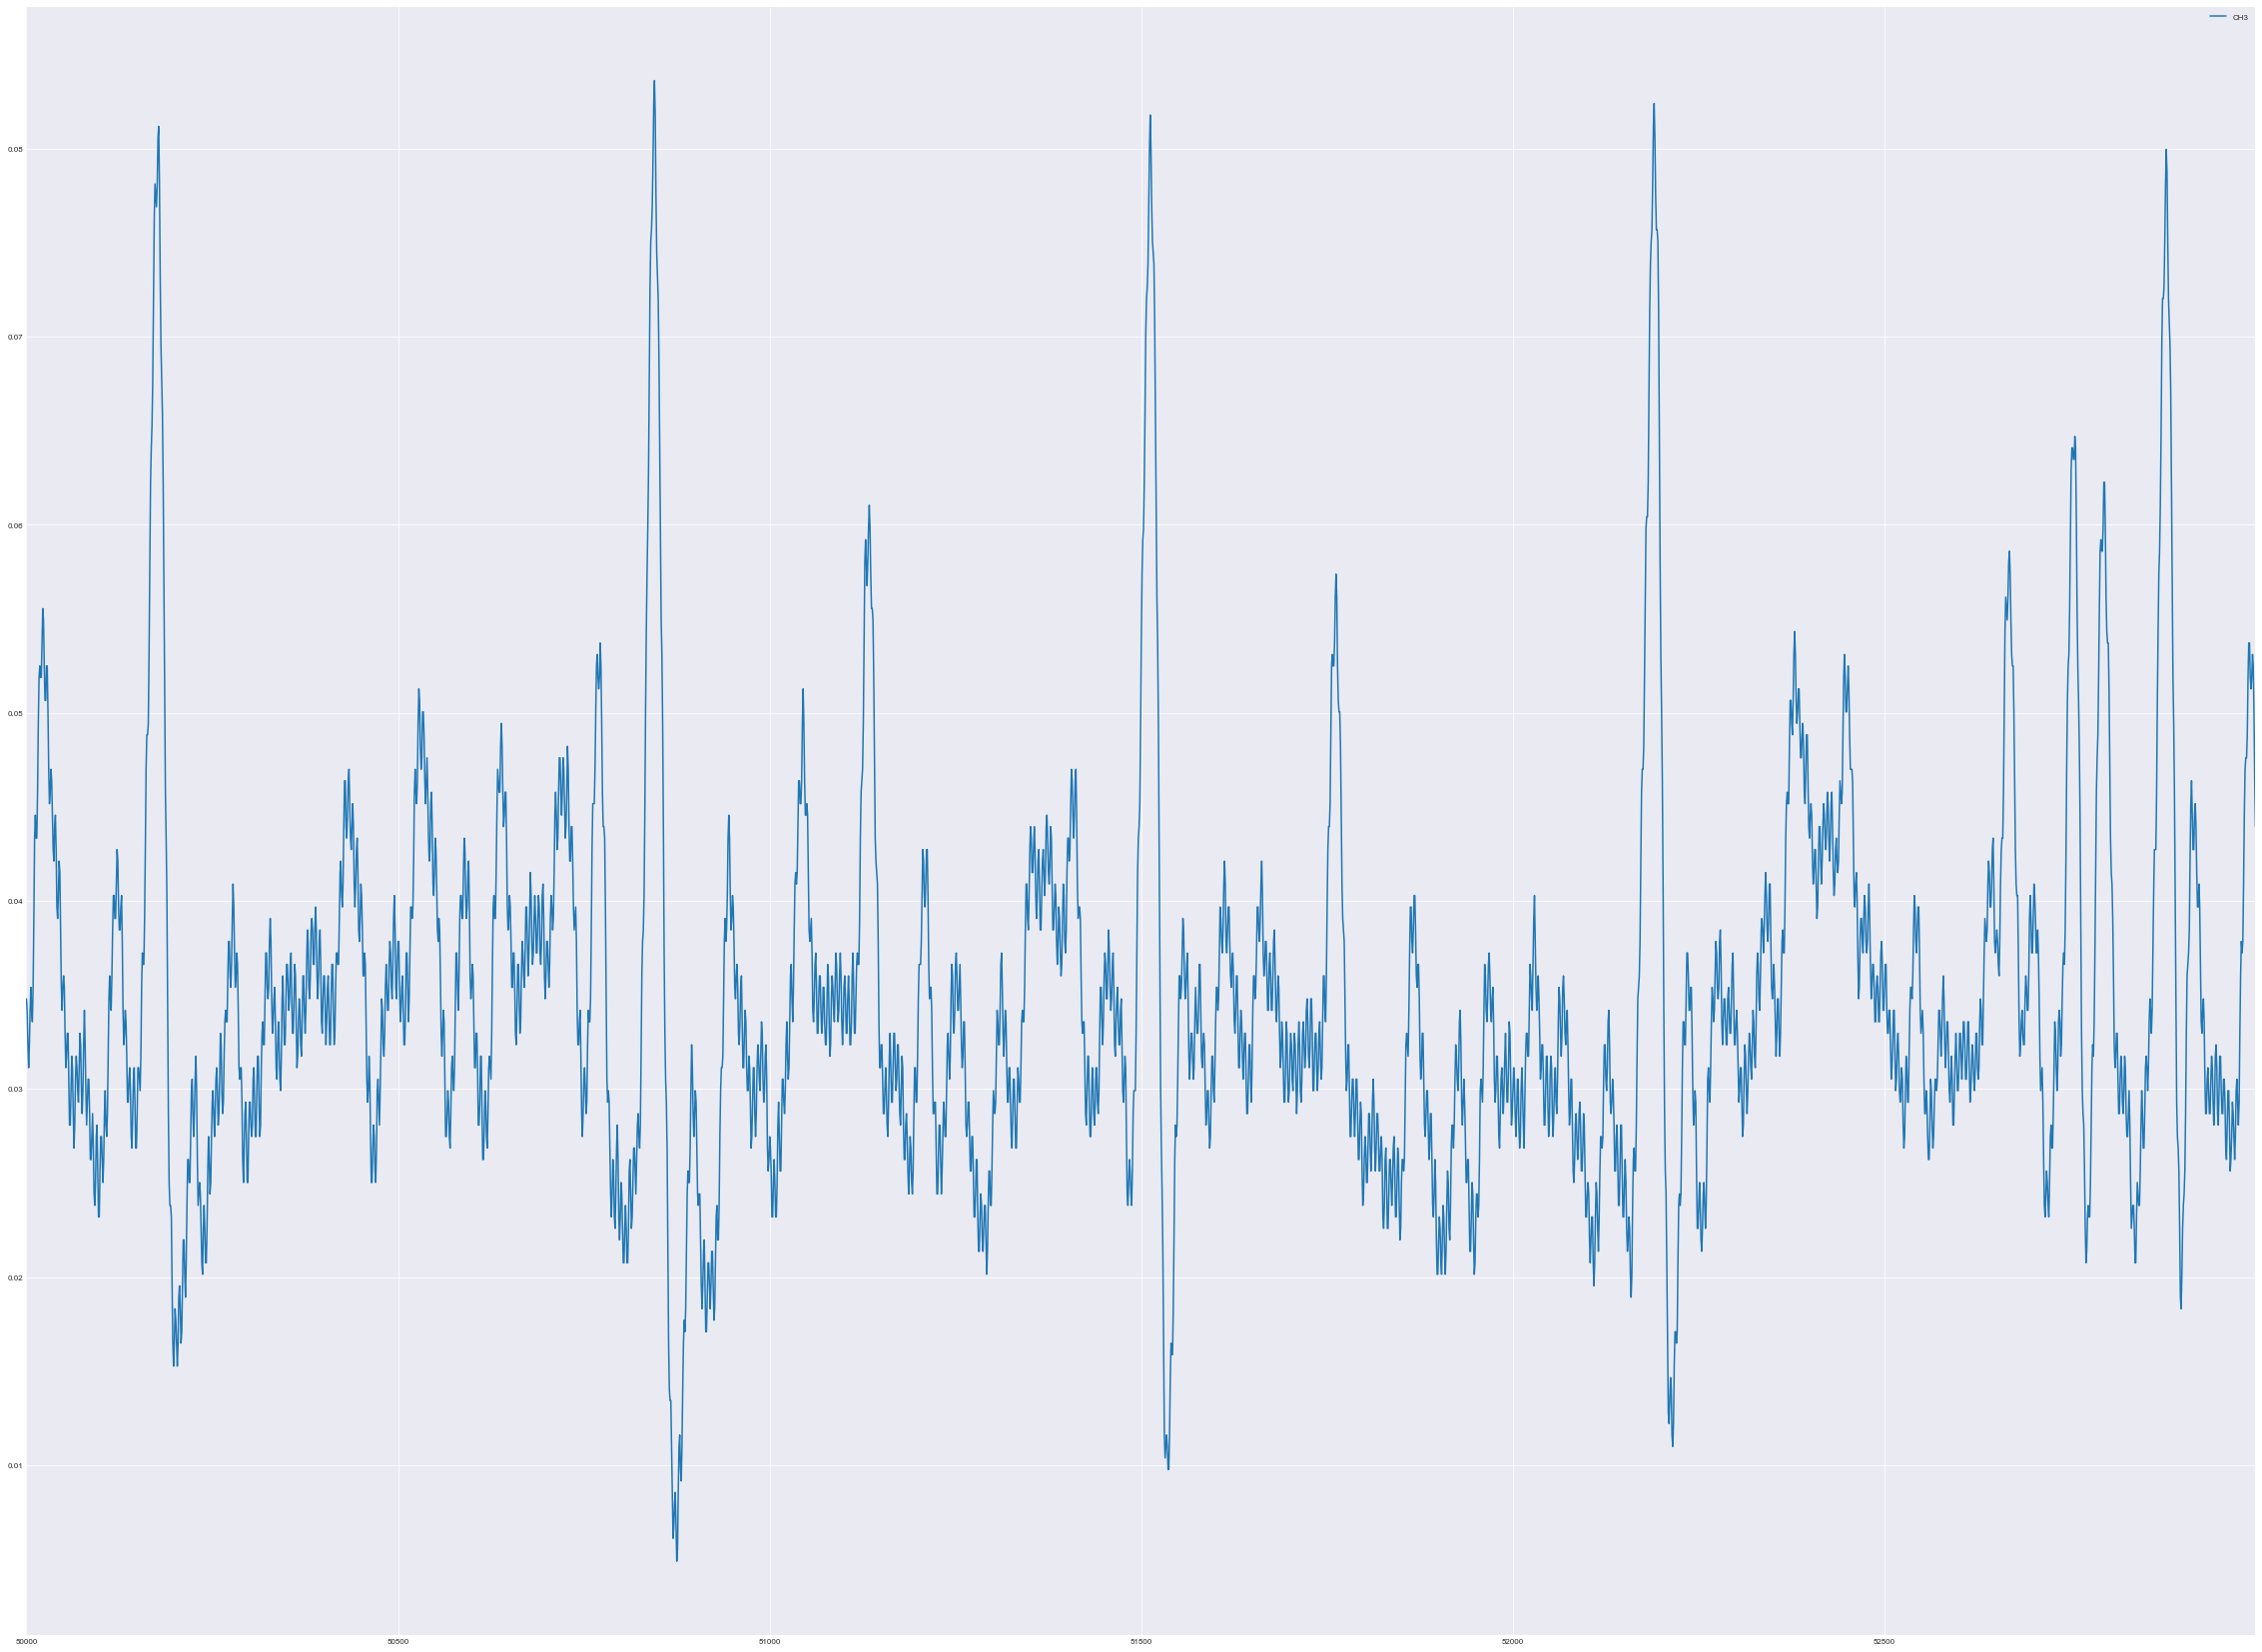

In [362]:
ecg_data[50000:53000].plot()

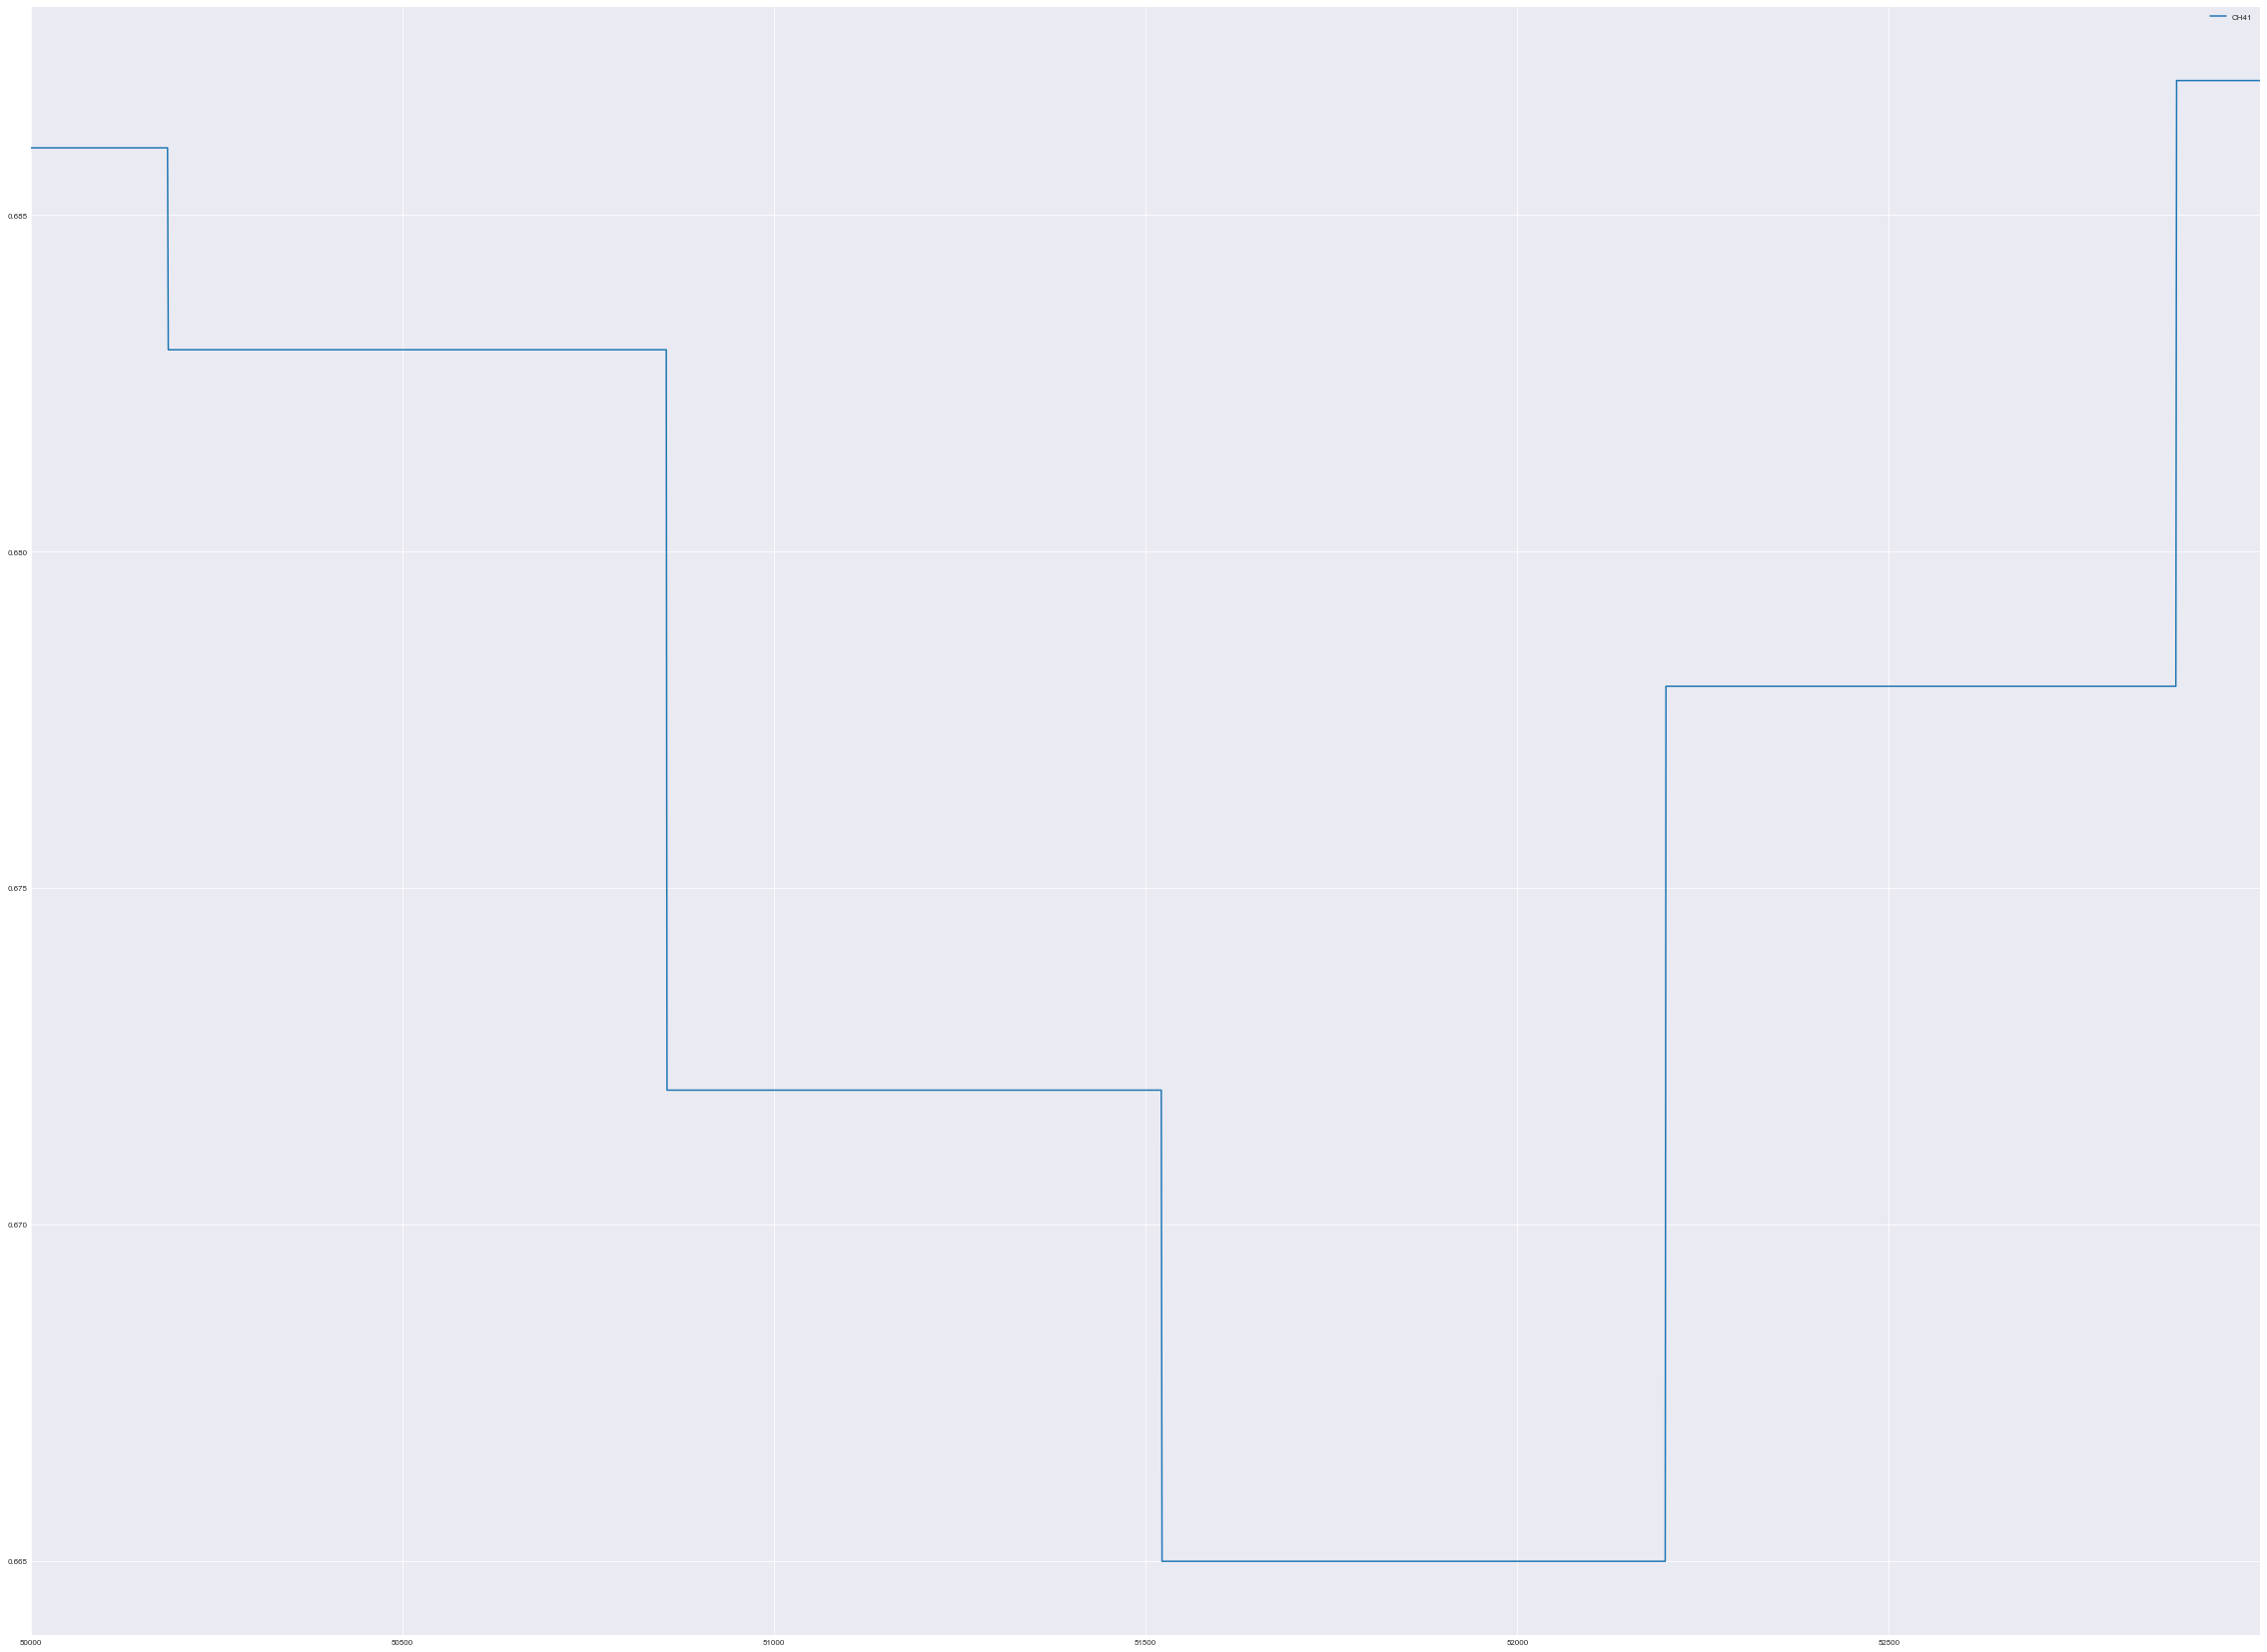

In [363]:
rr_intervals[50000:53000].plot()

In [364]:
import matplotlib.pyplot as plt

In [365]:
%pylab inline
pylab.rcParams['figure.figsize']= (40.0,30.0) #creating bigger figure

Populating the interactive namespace from numpy and matplotlib


/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fftpack', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


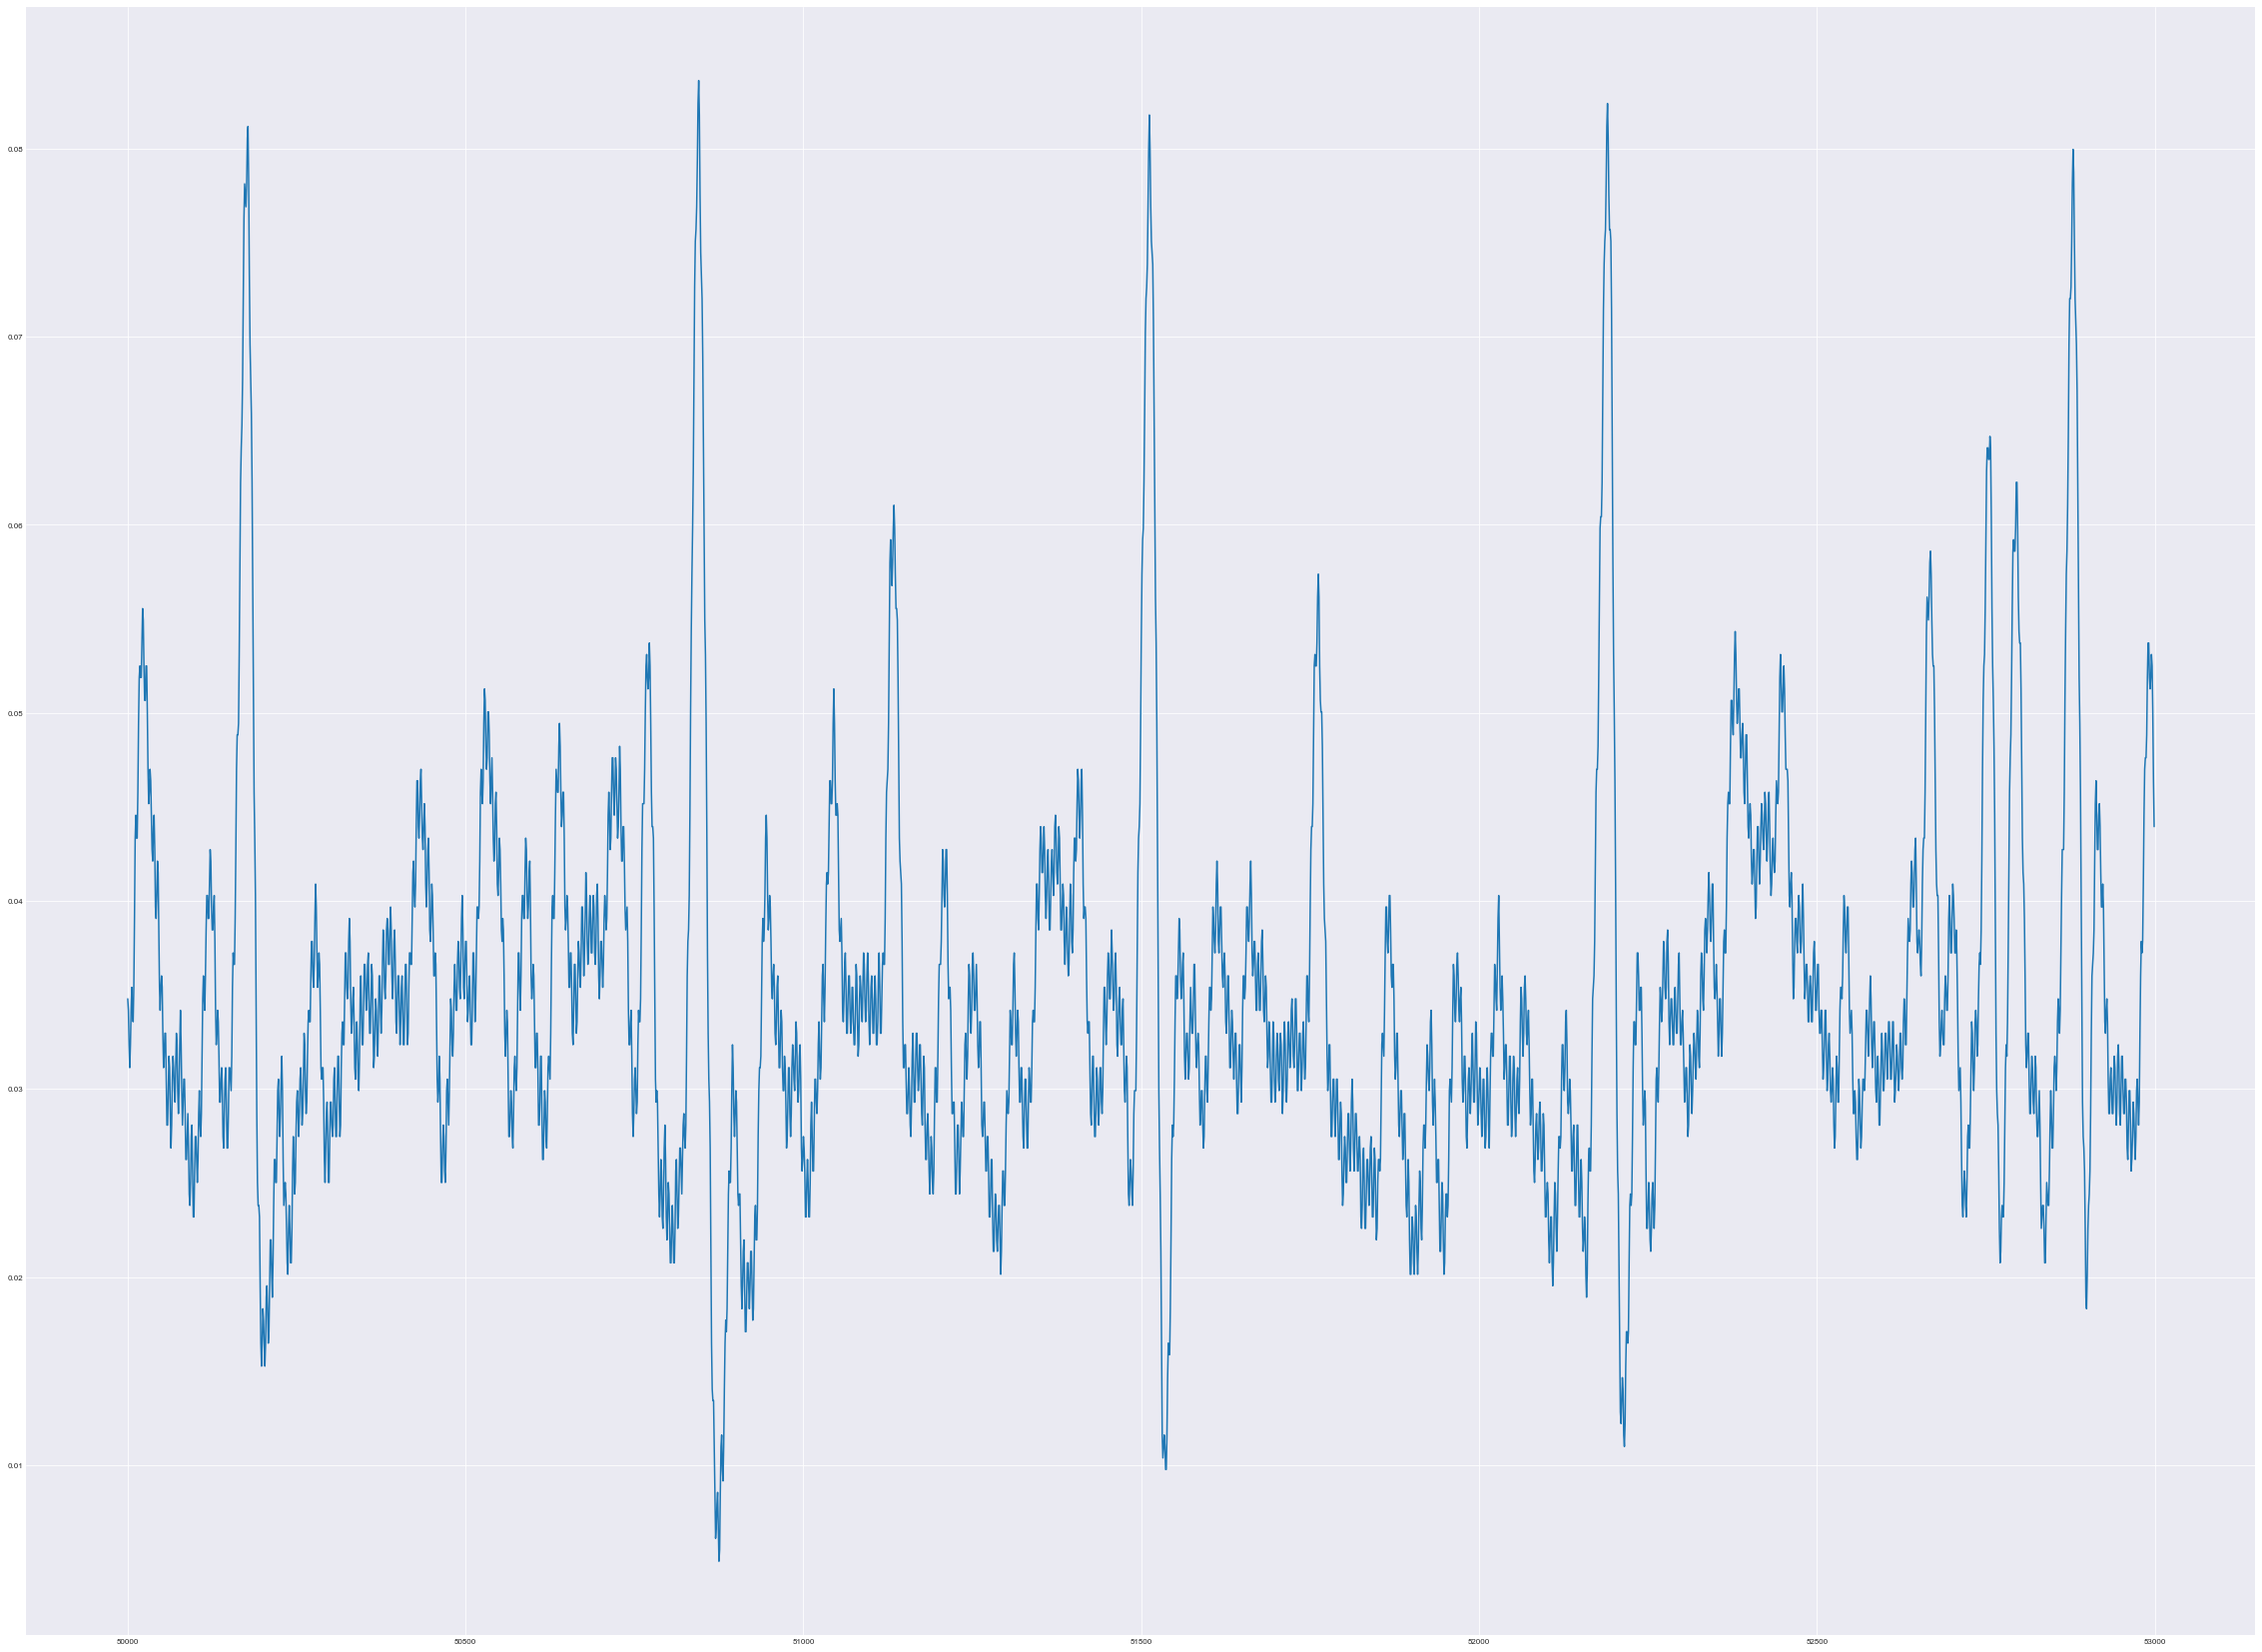

In [366]:
plt.plot(ecg_data[50000:53000])

In [367]:
df_polar=pd.read_csv('./data/M/_slash_polar.csv',header=[0])

In [368]:
#df_polar.columns = ['NA', 'hr_min_sec_ms__bpm__rr']
df_polar.head() #data from Polar device has been streamed as string and needs to be pre-processed and disected 

rosbagTimestamp                     data
0         36000000  "15_07_51_723, 85, 689"
1        172000000  "15_07_52_712, 86, 685"
2        334000000  "15_07_53_702, 86, 700"
3        457000000  "15_07_54_692, 86, 731"
4        566000000  "15_07_55_682, 84, 777"

In [369]:
polar_t_bpm_rr=df_polar['data'].str.split(',', expand=True)
#rename header
polar_t_bpm_rr.columns=['t','bpm','rr']
polar_t_bpm_rr['rosbagTimestamp']=df_polar['rosbagTimestamp']

In [370]:
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].str.replace('"', '')
polar_t_bpm_rr.tail()

t  bpm    rr  rosbagTimestamp
452  "15_15_23_664   87   740     196198000000
453  "15_15_24_654   86   728     196821000000
454  "15_15_25_644   87   699     197325000000
455  "15_15_26_634   89   661     197832000000
456  "15_15_27_624   89   651     198380000000

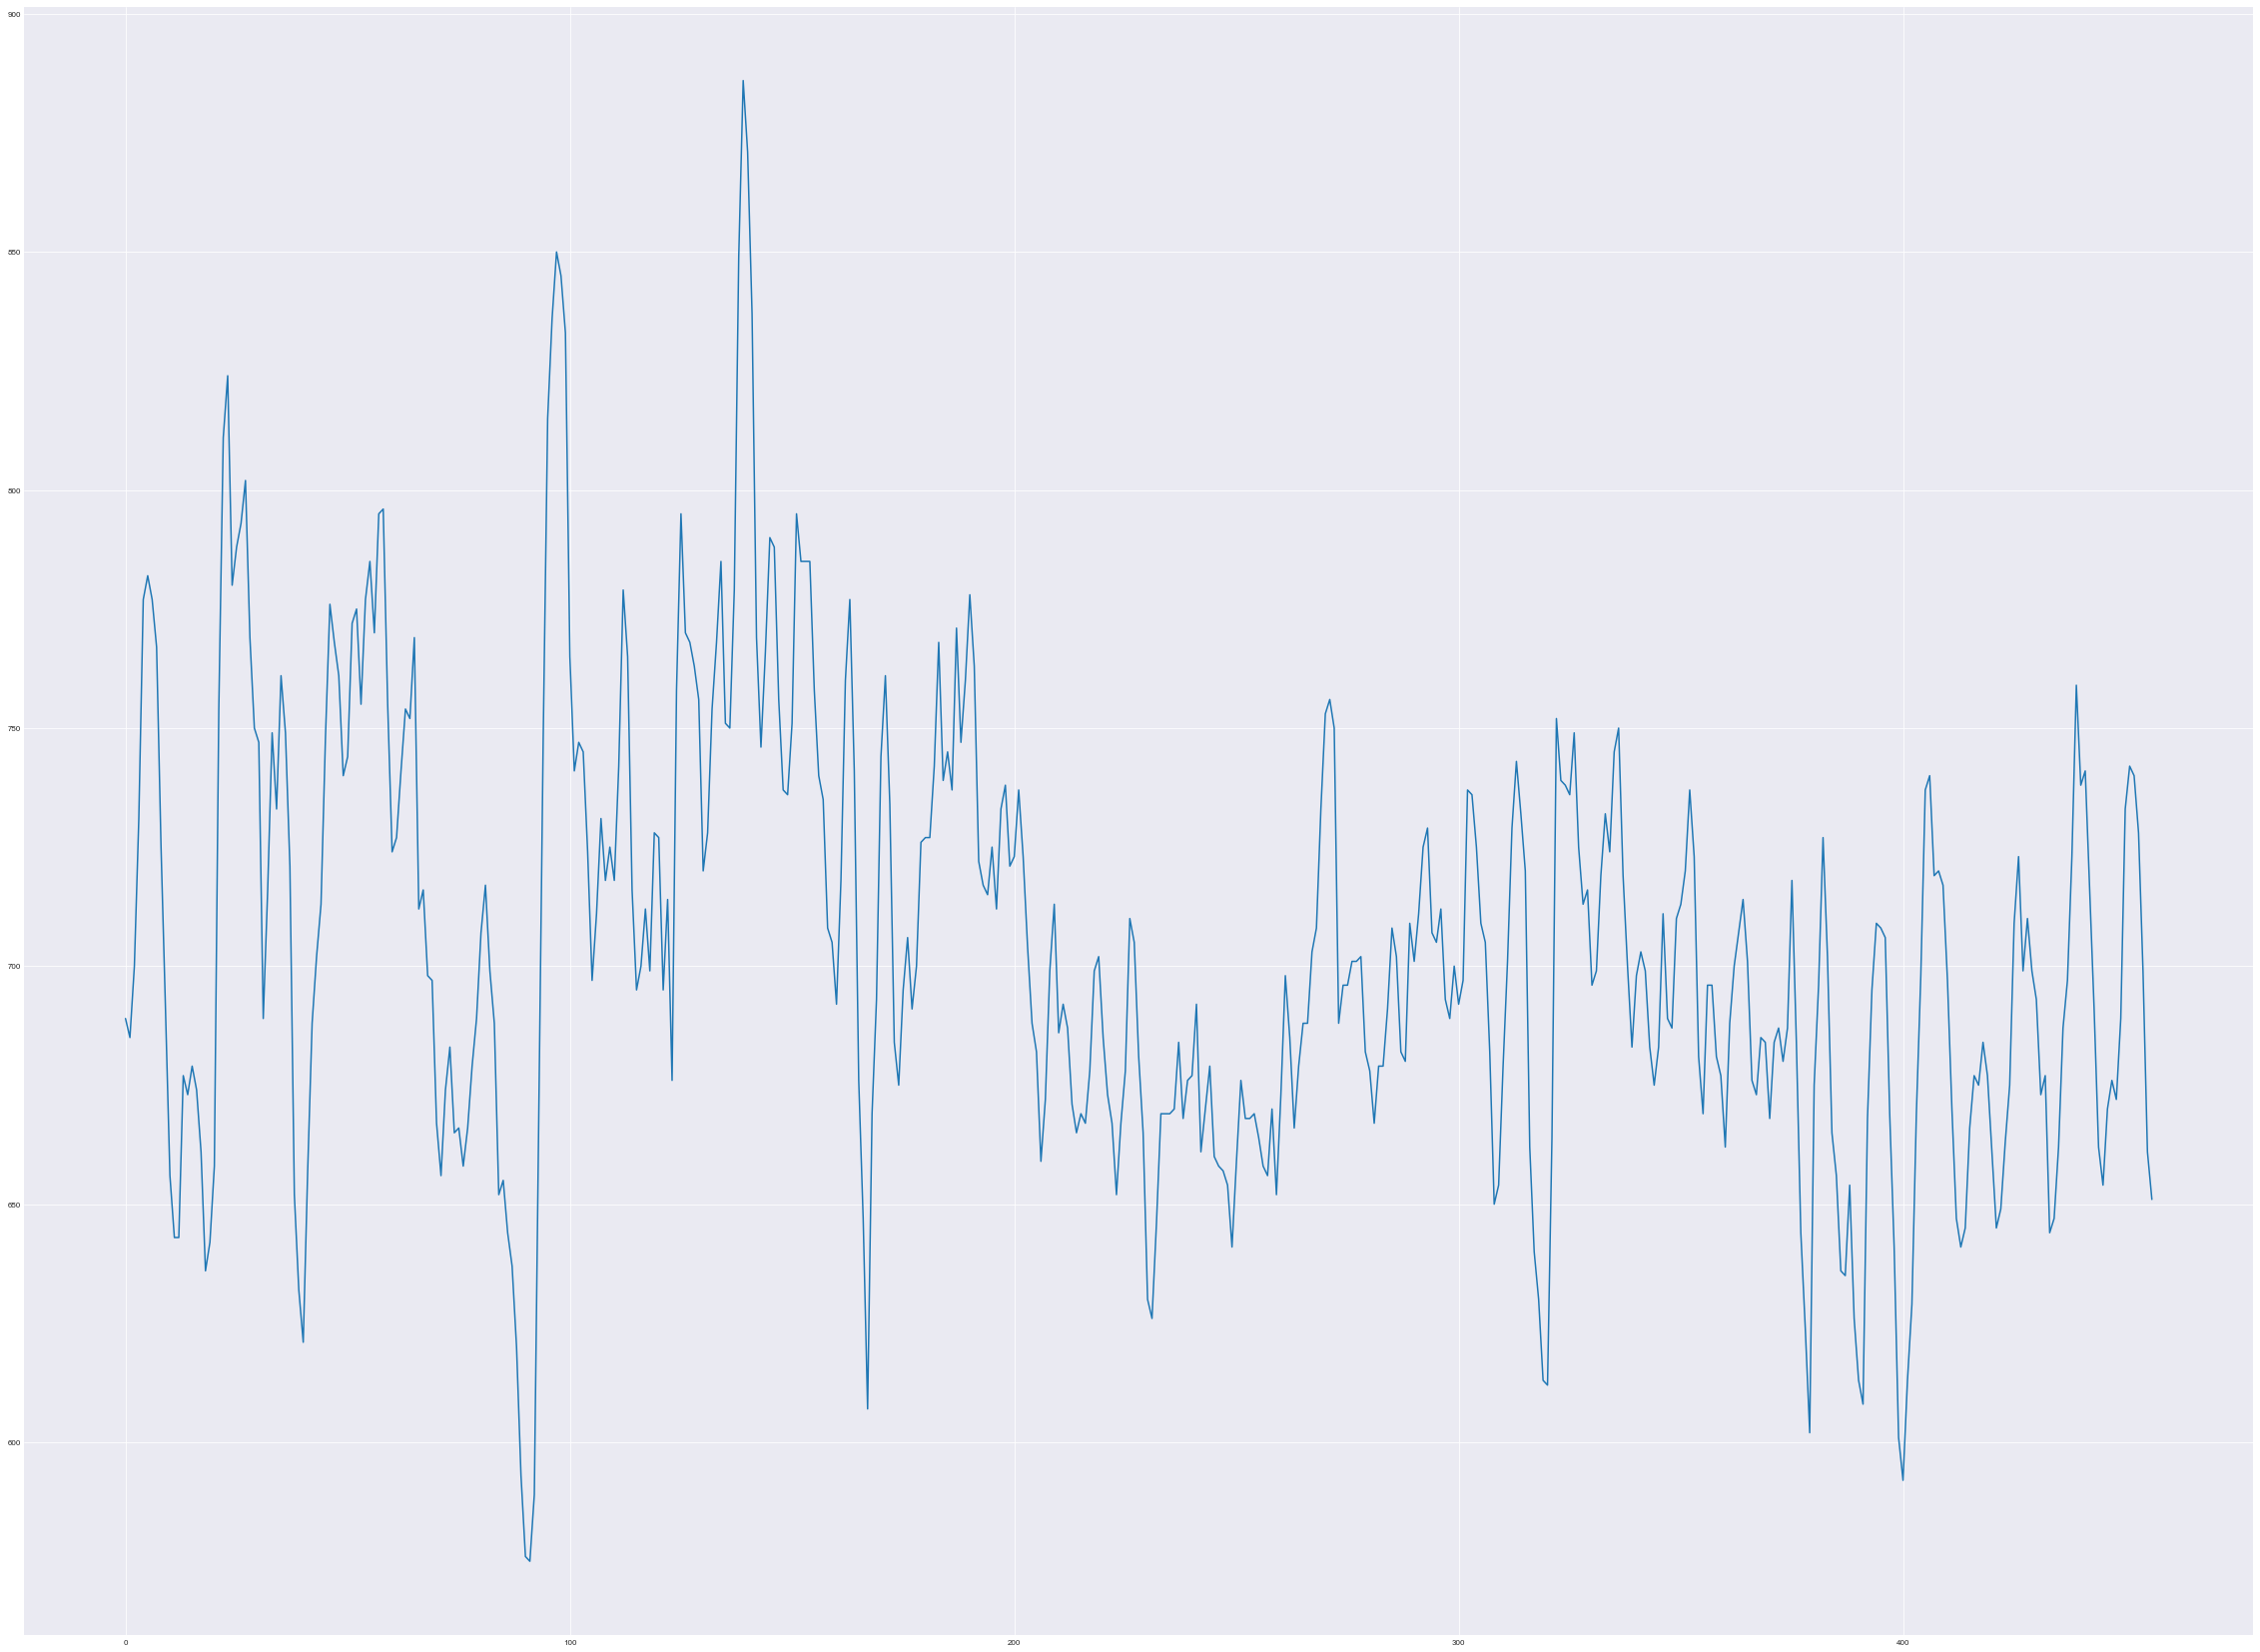

In [371]:
polar_t_bpm_rr['rr']=polar_t_bpm_rr['rr'].astype(int)
polar_t_bpm_rr['bpm']=polar_t_bpm_rr['bpm'].astype(int)
plt.plot(polar_t_bpm_rr['rr'])

In [372]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

from hrvanalysis import get_time_domain_features, plot_psd, plot_distrib

# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=polar_t_bpm_rr['rr'],  low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

time_domain_features = get_time_domain_features(interpolated_nn_intervals)


0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.


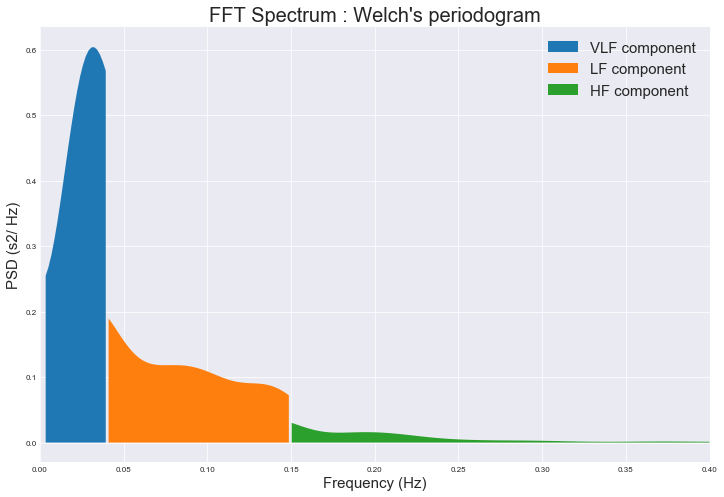

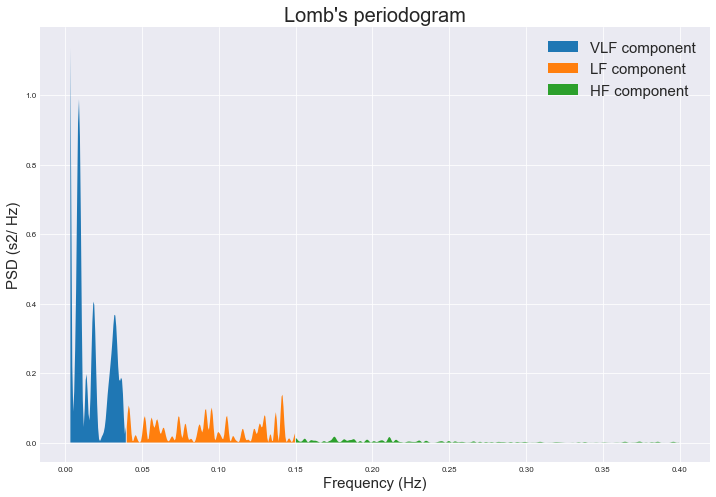

In [373]:
time_domain_features

plot_psd(interpolated_nn_intervals, method="welch")
plot_psd(interpolated_nn_intervals, method="lomb")

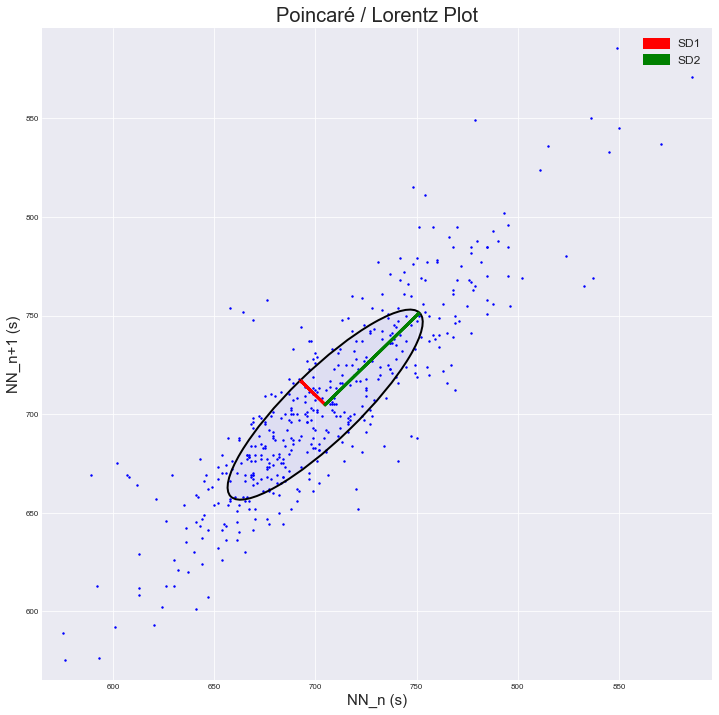

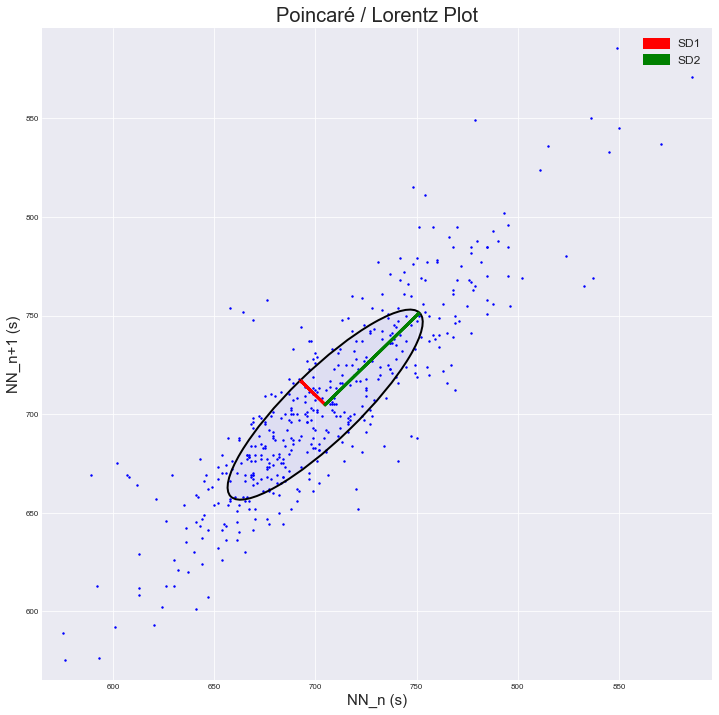

In [374]:
from hrvanalysis import plot_poincare


plot_poincare(interpolated_nn_intervals)
plot_poincare(interpolated_nn_intervals, plot_sd_features=True)

In [375]:
from hrv.classical import time_domain

rri = interpolated_rr_intervals
results = time_domain(rri)
print(results)

{'rmssd': 23.874764626377207, 'sdnn': 47.79455456476181, 'nn50': 21, 'pnn50': 4.595185995623632, 'mrri': 704.8052516411378, 'mhr': 85.51534712327309}


In [376]:
rriBioIn = [i * 1000 for i in list(rr_intervals['CH41'])]
rriBio = remove_outliers(rr_intervals=rriBioIn,  low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
rri_interpol_bio = interpolate_nan_values(rr_intervals=rriBio, interpolation_method="linear")
rri_interpol_bio = np.asarray(rri_interpol_bio)
tmp = rri_interpol_bio[np.logical_not(np.isnan(rri_interpol_bio))]
rri_interpol_bio = tmp.tolist()
results = time_domain(rri_interpol_bio)
print(results)

1327 outlier(s) have been deleted.
The outlier(s) value(s) are : [301595000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [377]:
size(rri_interpol_bio)

300269

# Plotting RR intervals with different sampling rates in one plot



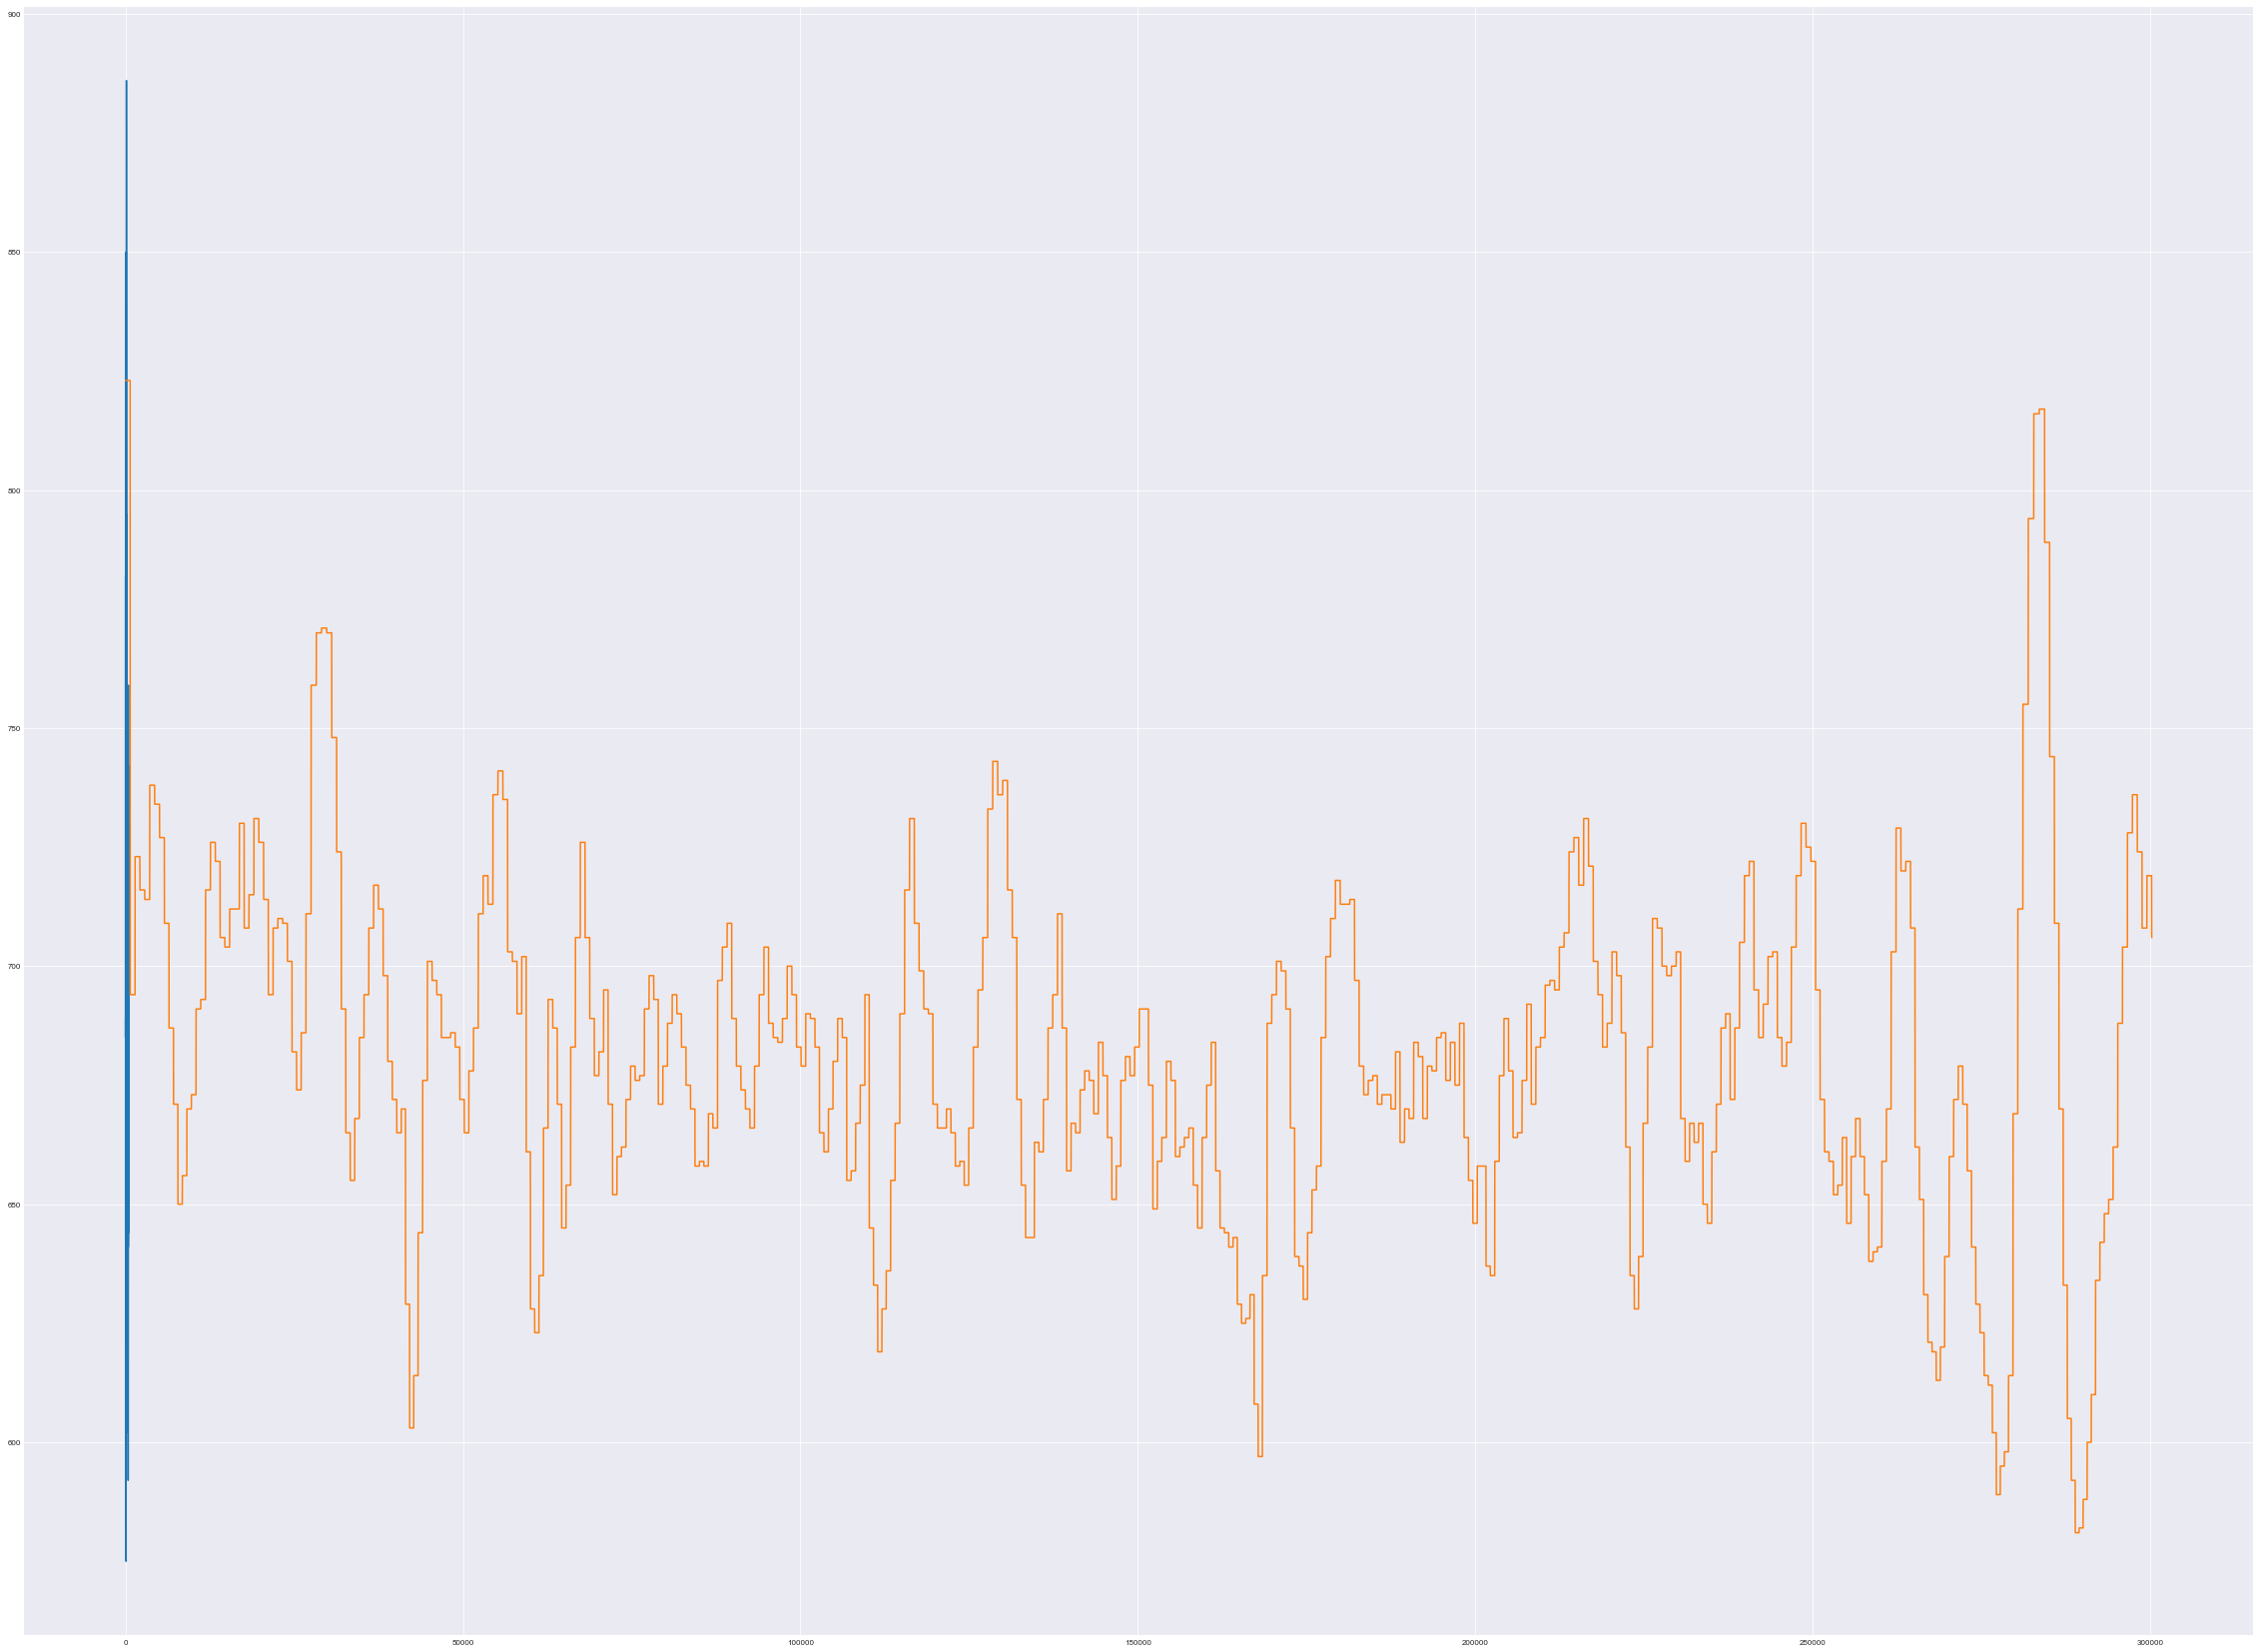

In [378]:
plt.plot(rri)
plt.plot(rri_interpol_bio)

# Dynamic Time Warping

In [379]:
from dtwalign import dtw

x = np.array(rri)
y = np.array(rri_interpol_bio)
res = dtw(x, y)
print(res)


/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/kaufmann/anaconda3/envs/bh/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


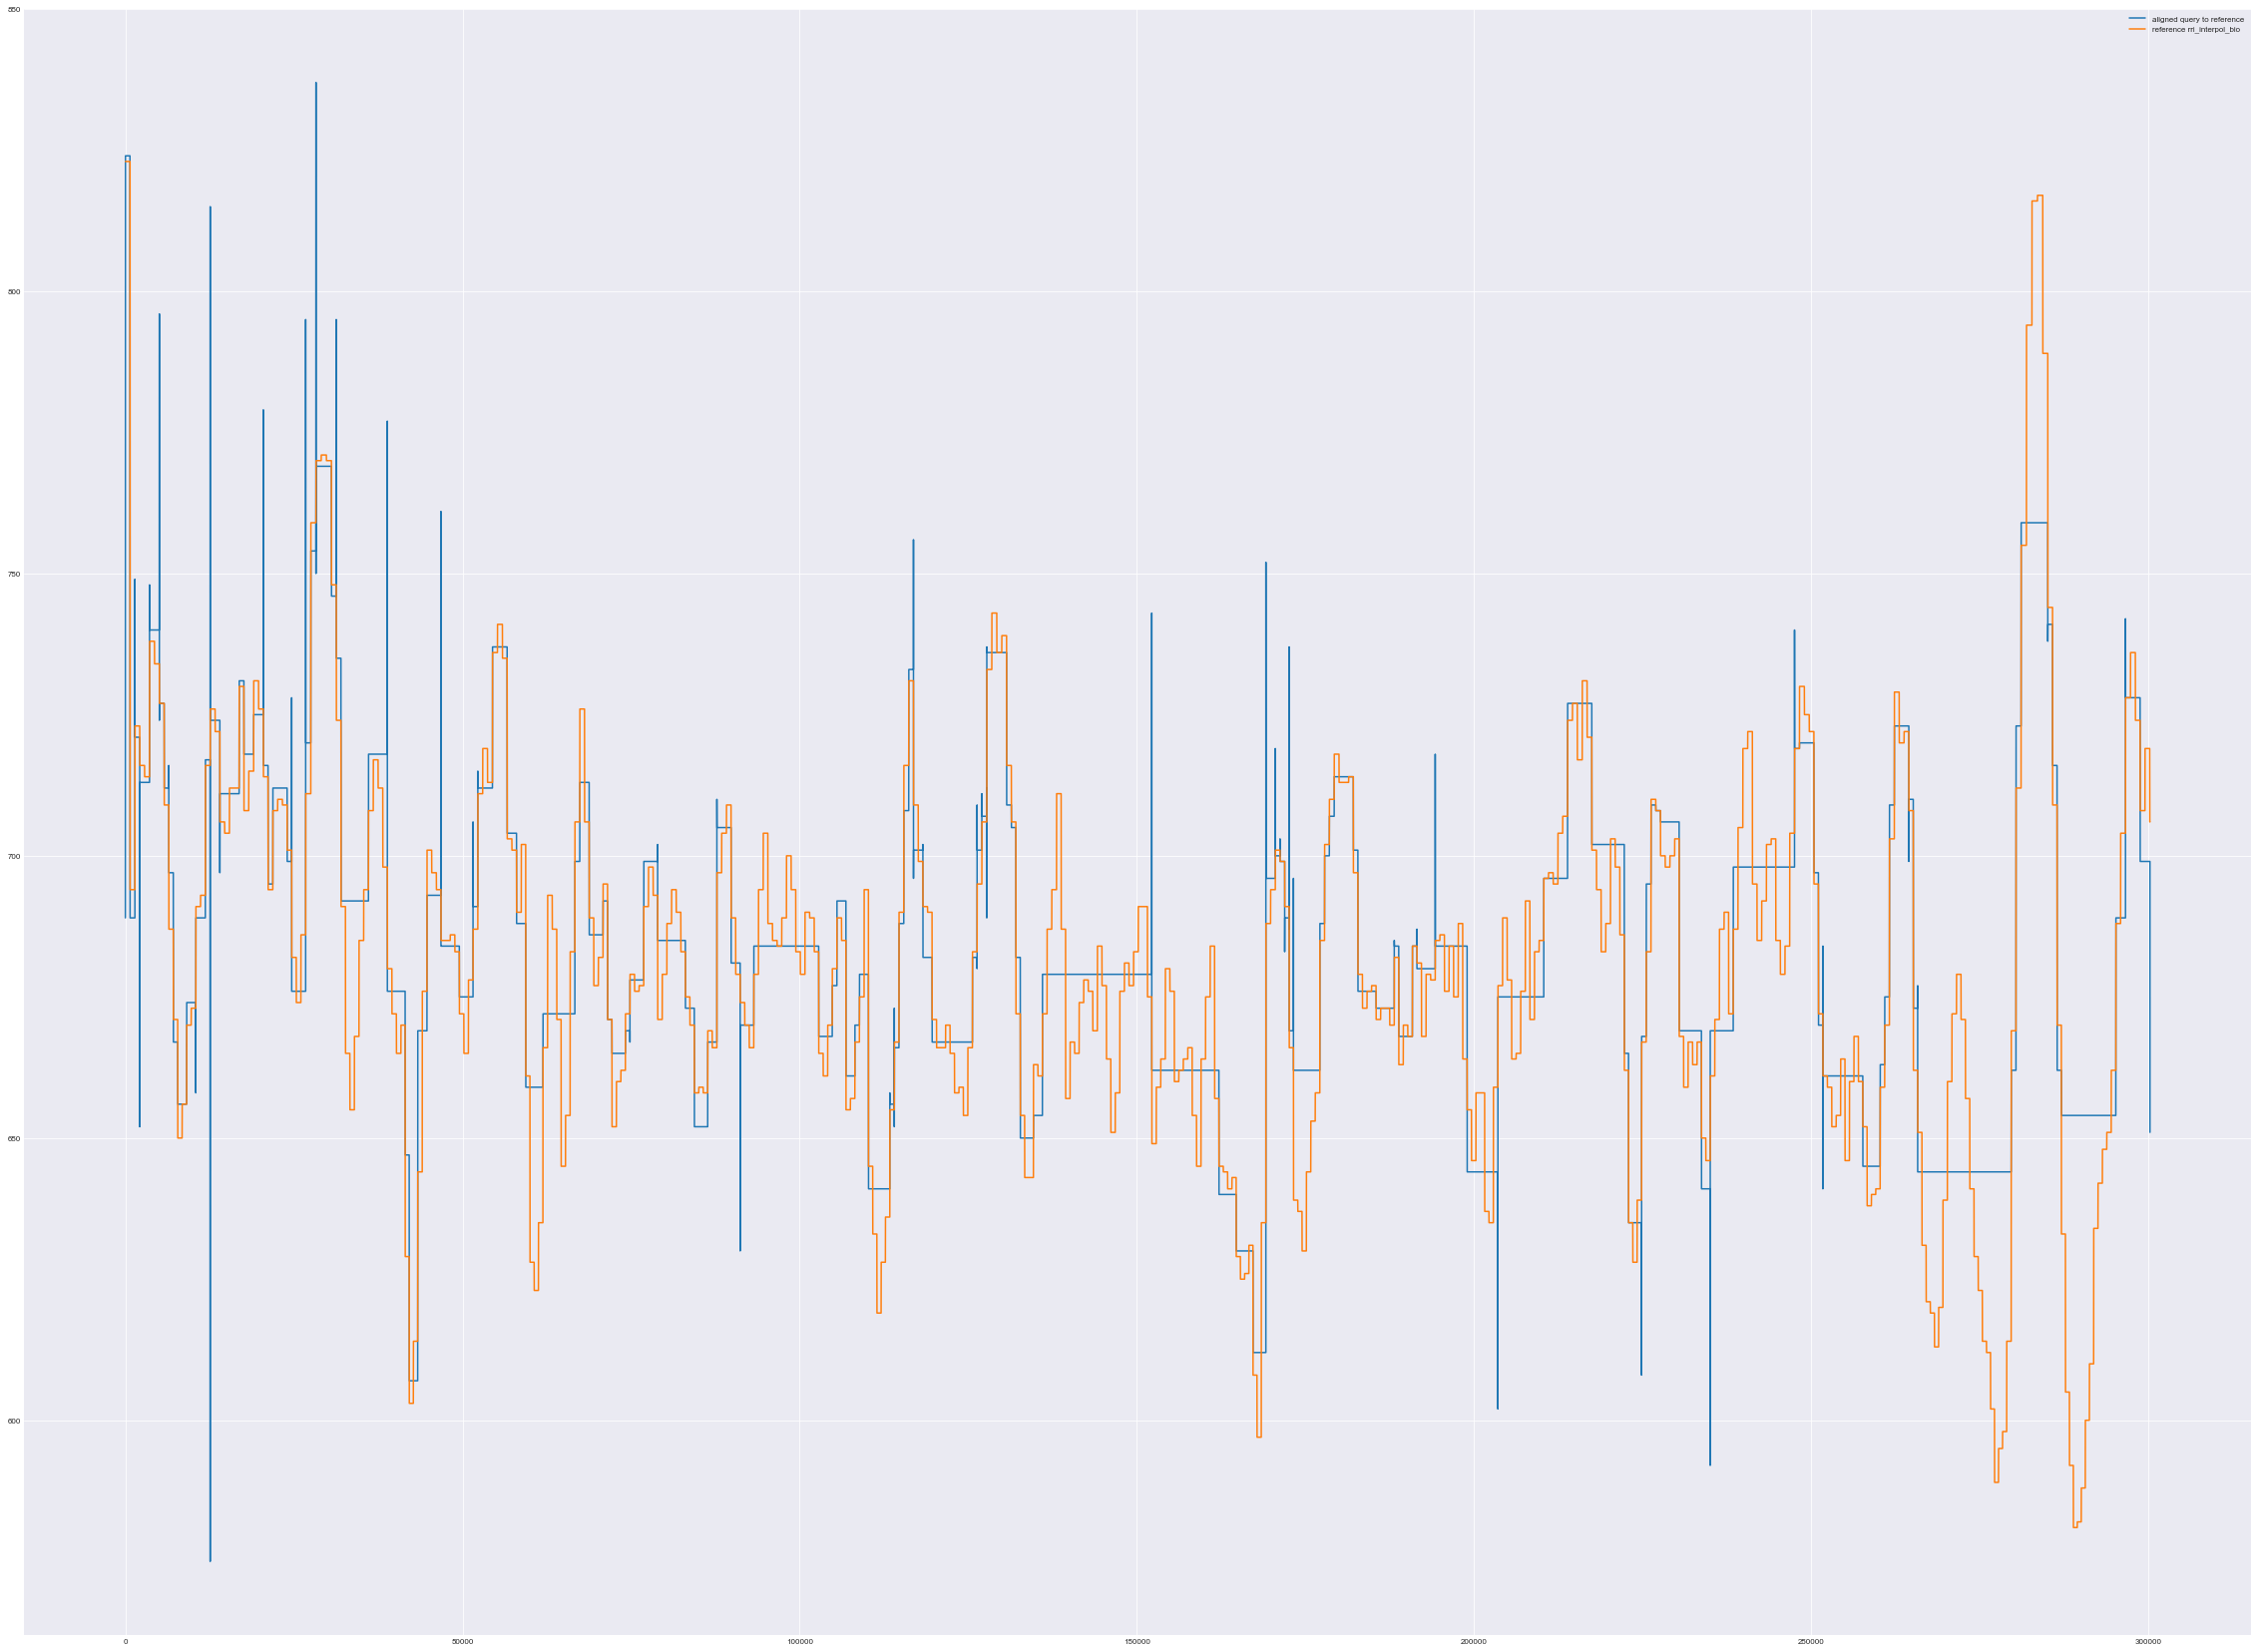

In [380]:
# warp x to y
x_warping_path = res.get_warping_path(target="query")
plt.plot(x[x_warping_path], label="aligned query to reference")
plt.plot(y, label="reference rri_interpol_bio")
plt.legend()

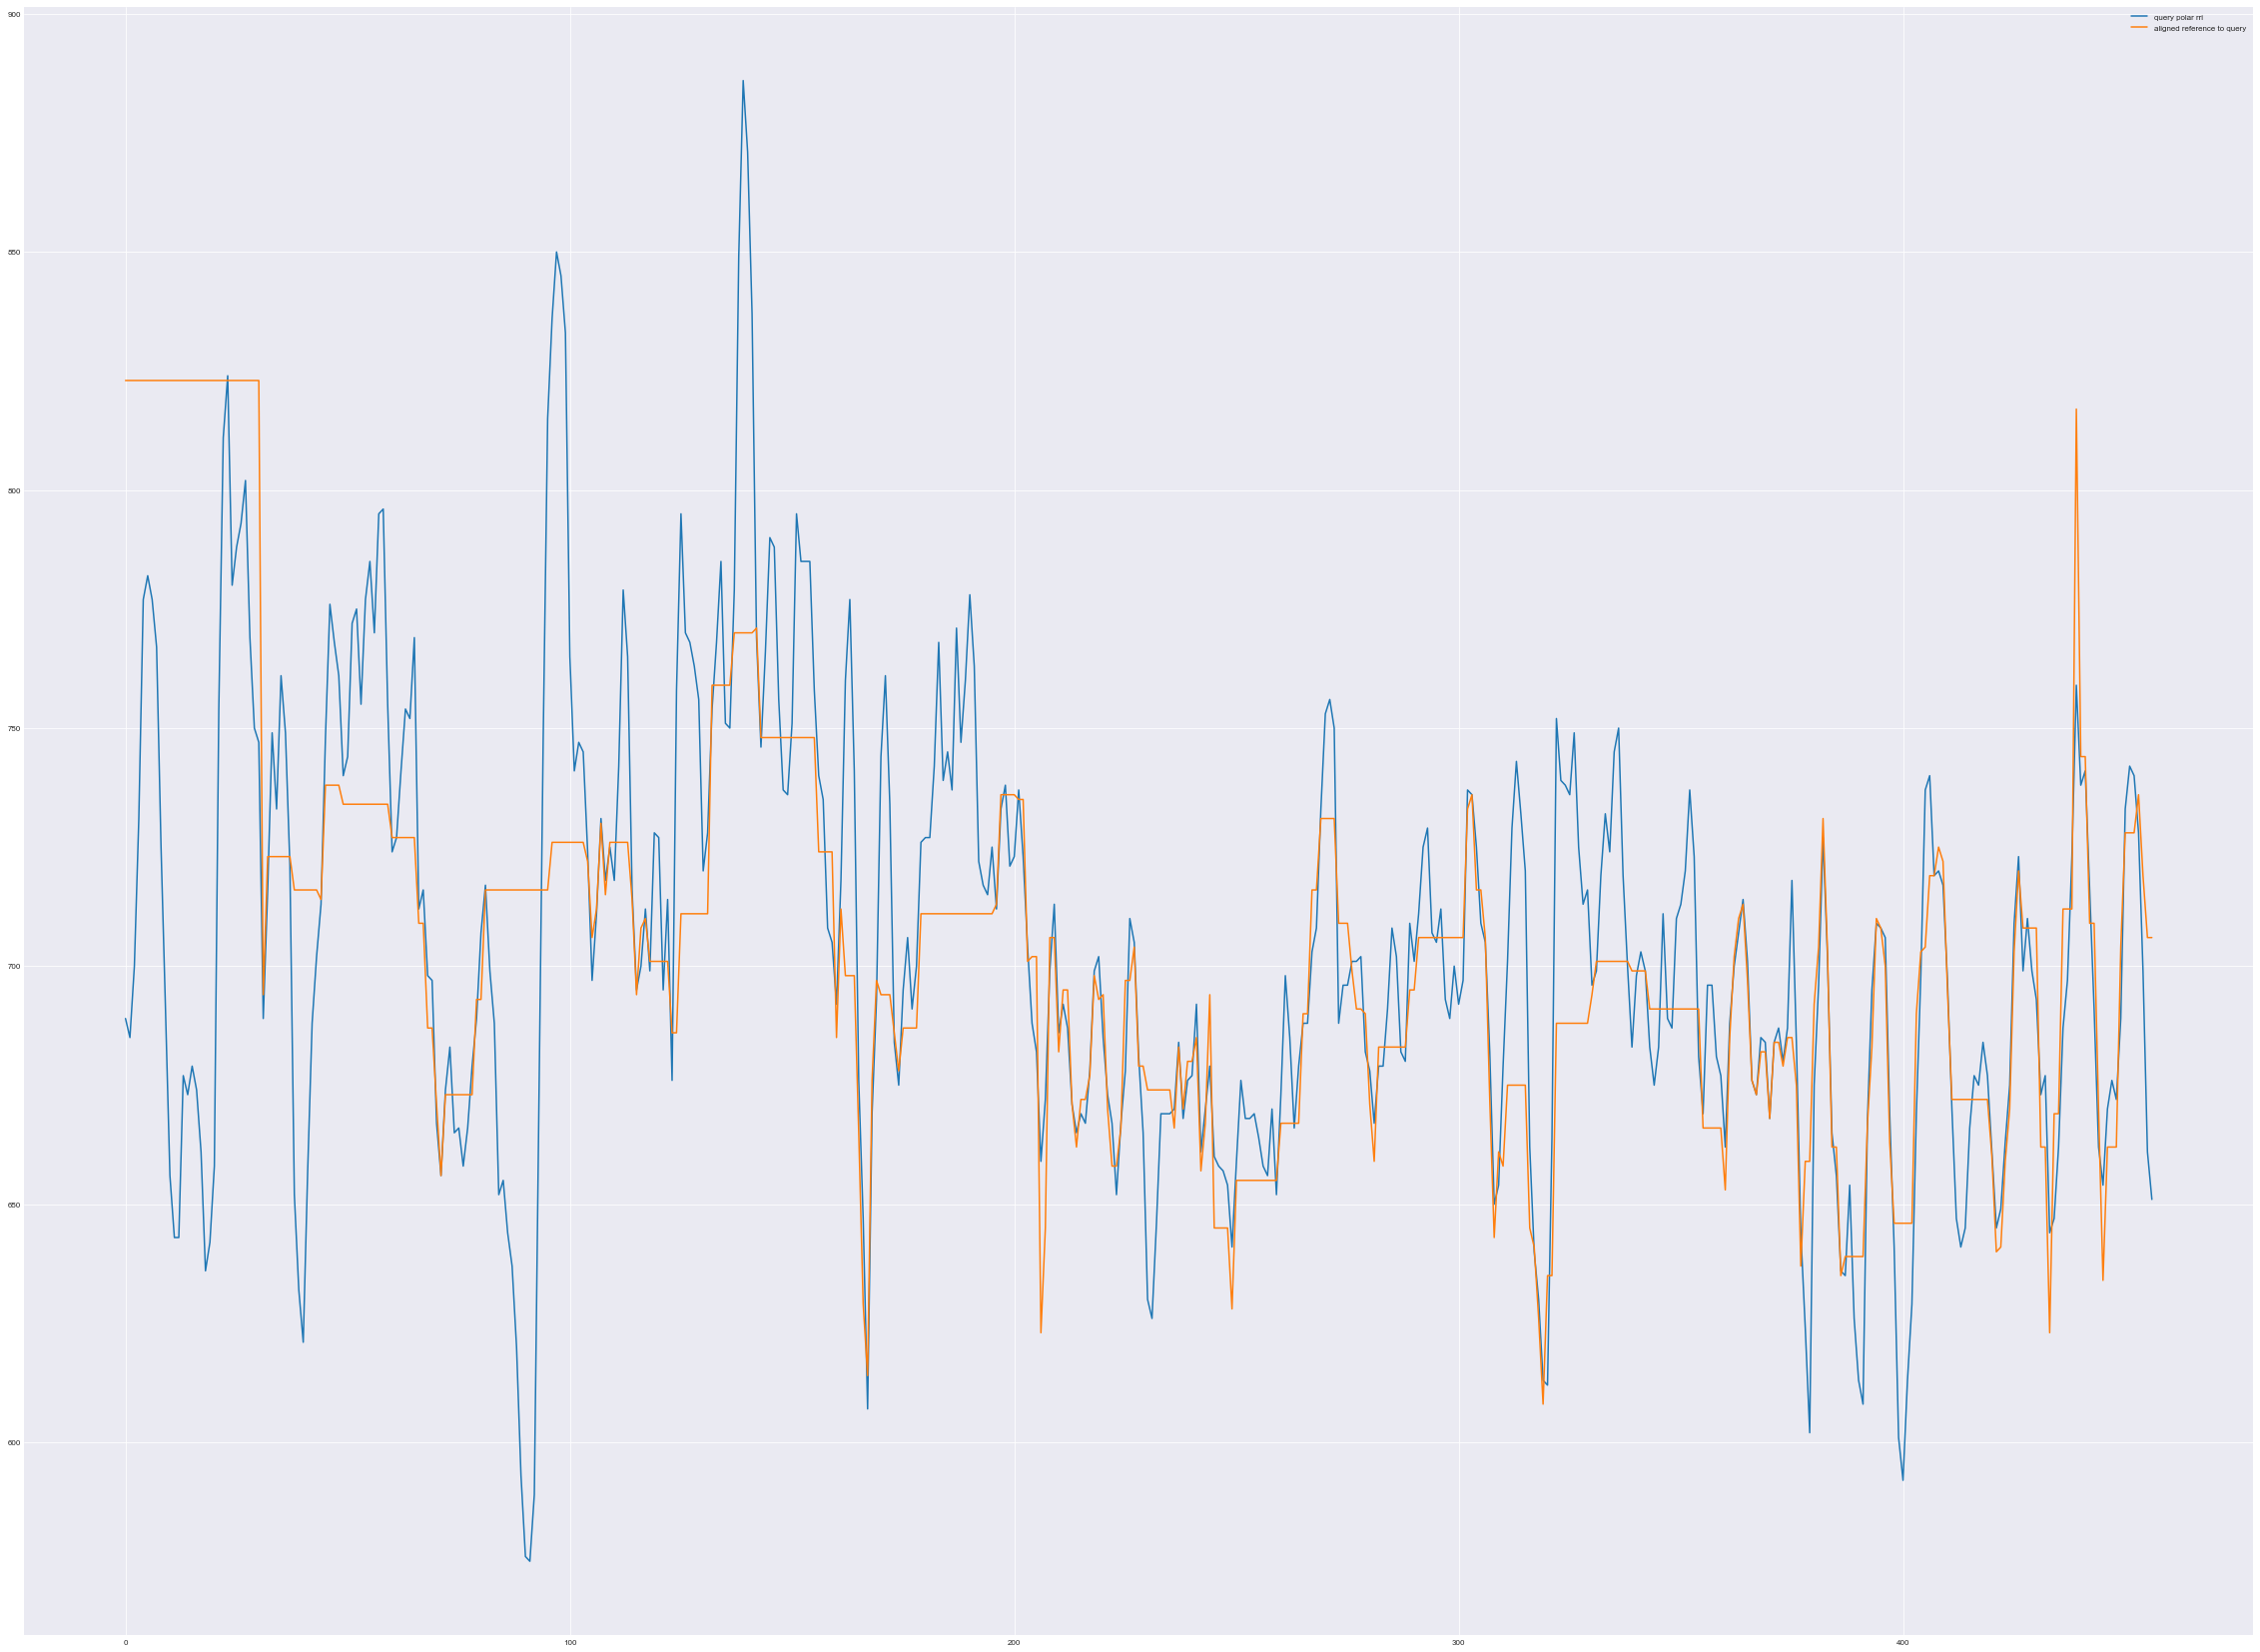

In [381]:
# warp y to x
y_warping_path = res.get_warping_path(target="reference")
plt.plot(x, label="query polar rri")
plt.plot(y[y_warping_path], label="aligned reference to query")
plt.legend()

In [382]:
#take biopac rri_interpol_bio and extract unique RR interval values
type(rri_interpol_bio)

list

In [383]:
def remove_adjacent(list_in):
  a = []
  for item in list_in:
    if len(a):
      if a[-1] != item:
        a.append(item)
    else: a.append(item)        
  return a

In [384]:
rri_interpol_bio_clean = remove_adjacent(rri_interpol_bio)

#### Plotting RR intervals for Polar (red) and cleaned Biopac (blue) with no repeating values

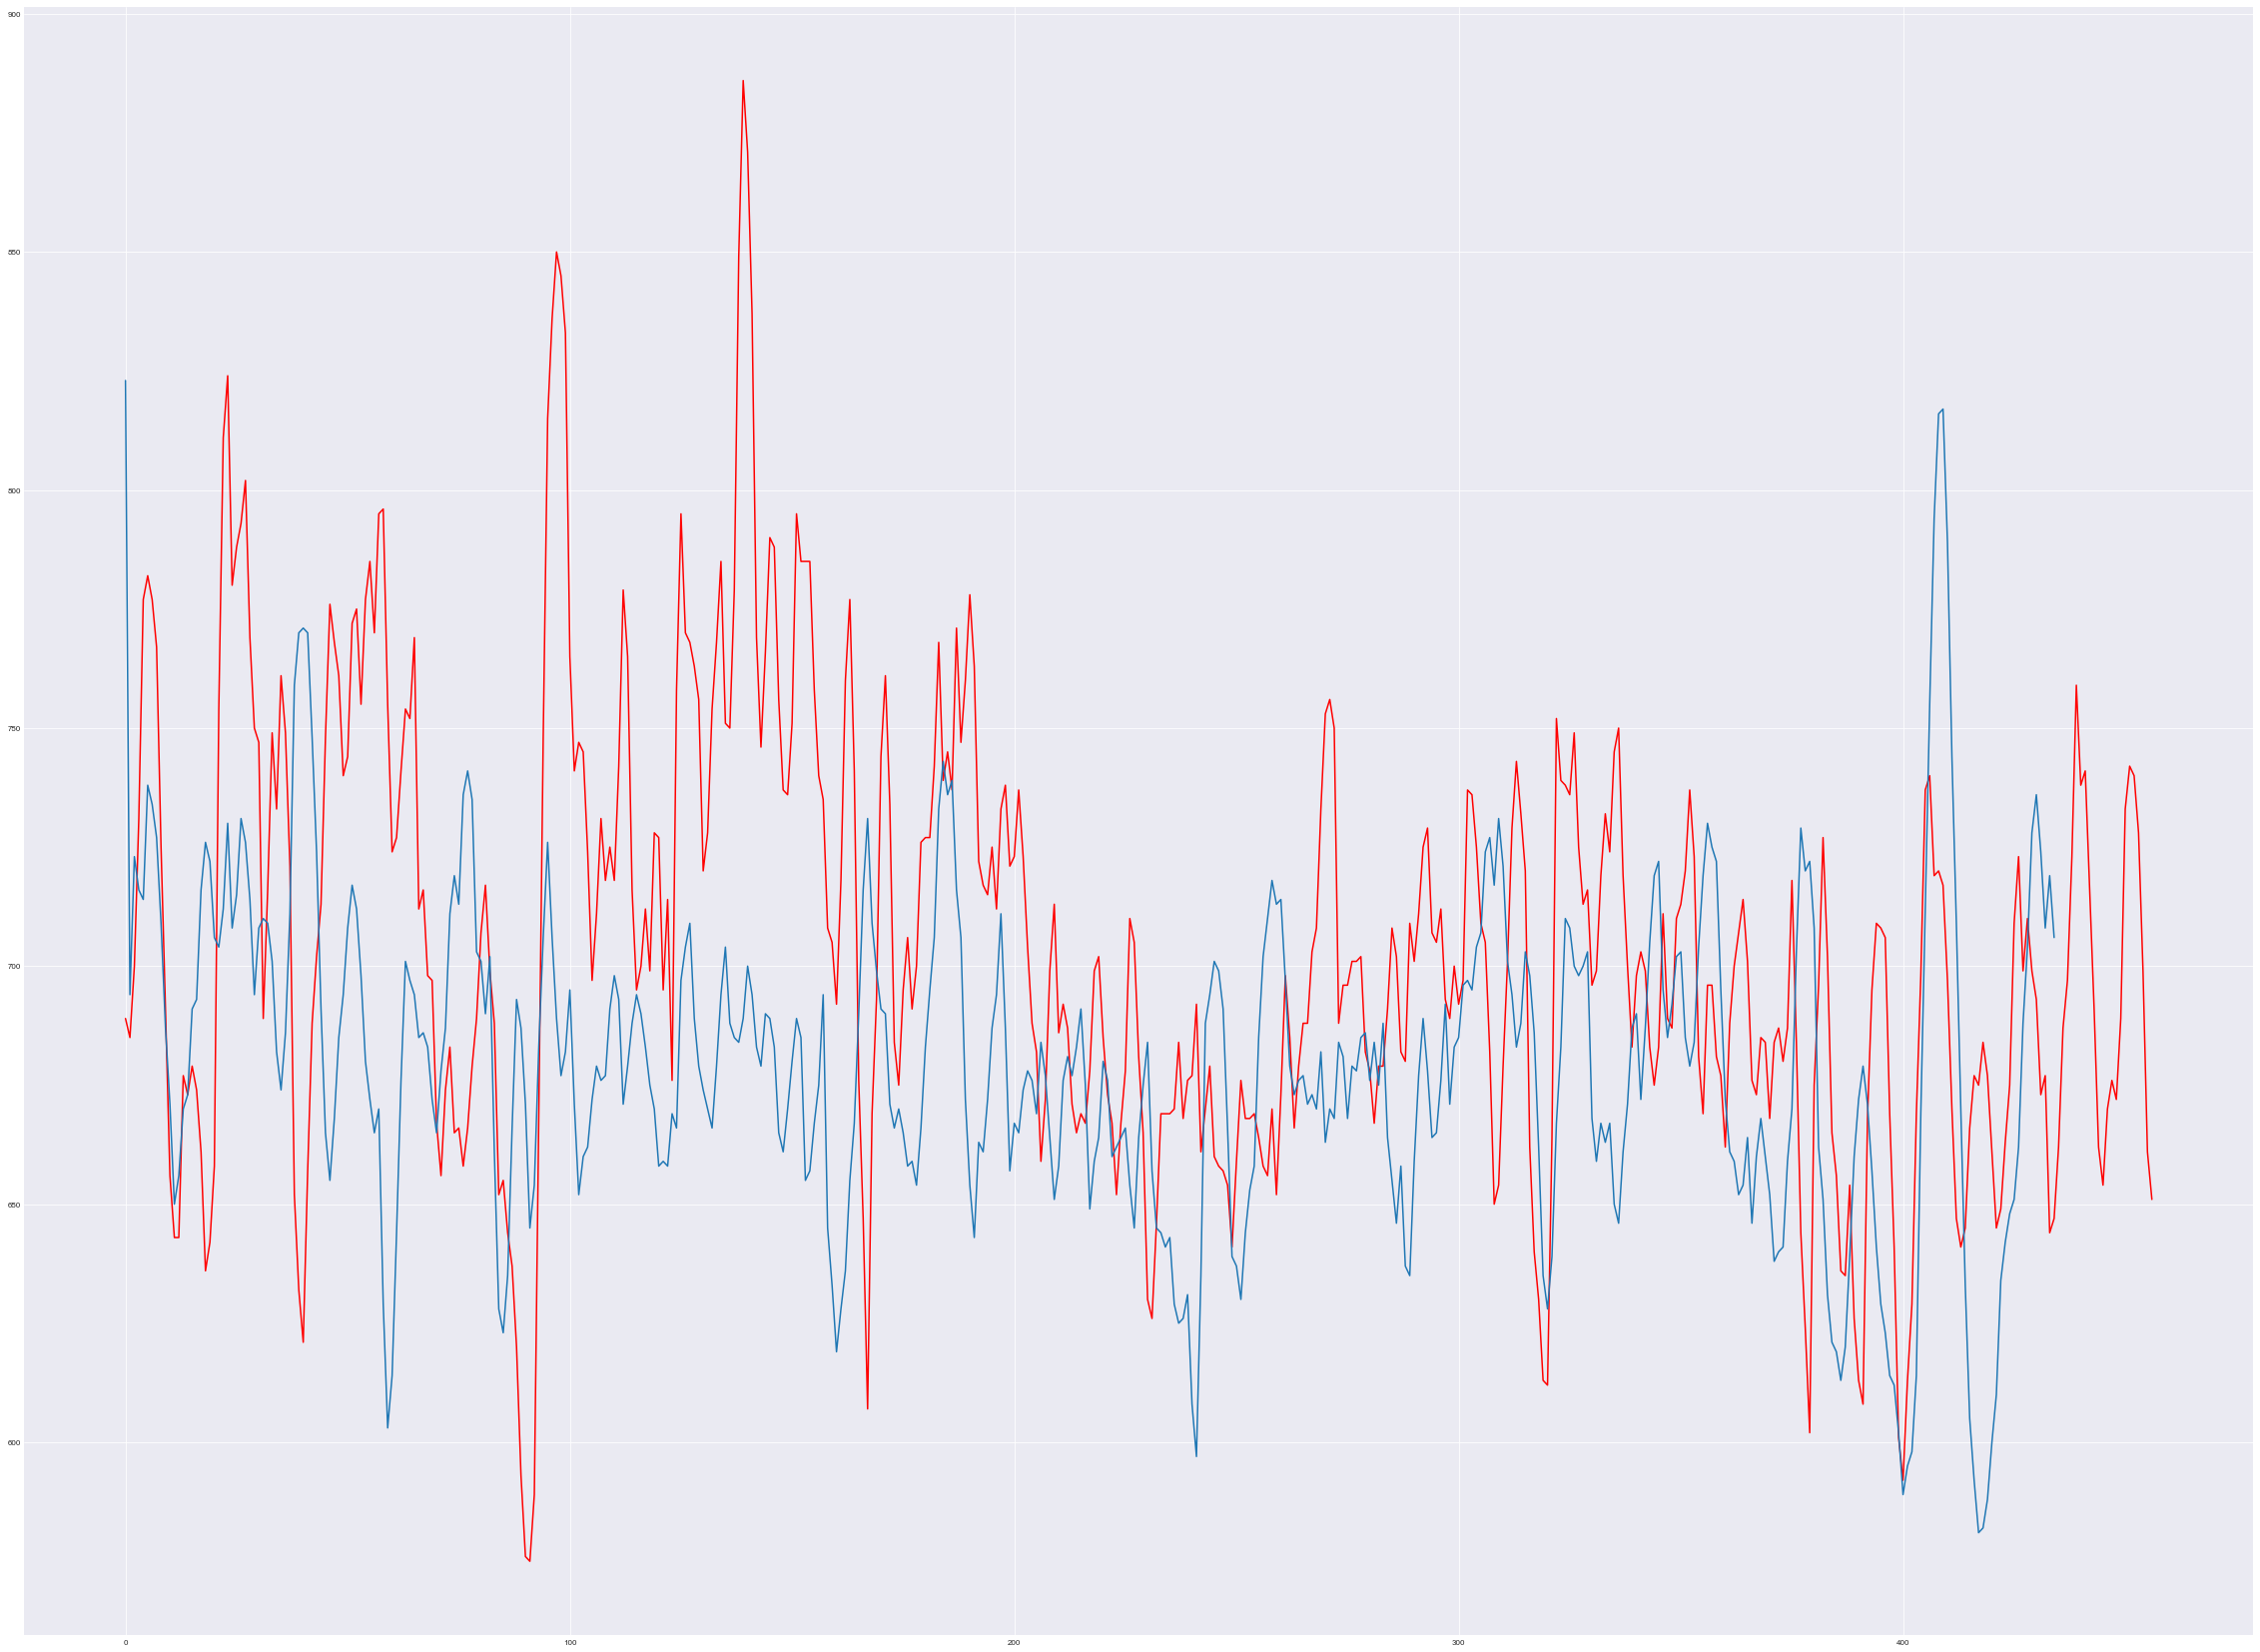

In [385]:
plt.plot(rri, label="POLAR RRI", color="red")
plt.plot(rri_interpol_bio_clean, label = "Biopac Cleaned")

# Pupillometry

In [386]:
fileNamePupil = '/Users/kaufmann/ecg_pupillometry_pipeline_kaufmann/data/M/_slash_pupil_info.csv'

In [387]:
df_pupil=pd.read_csv(fileNamePupil)

In [388]:
size(df_pupil)

404987

In [389]:
df_pupil

rosbagTimestamp    timestamp  index  confidence  \
0             36000000  5227.816895      0    0.999960   
1             36000000  5227.825195      0    0.998953   
2             36000000  5227.833008      0    0.991190   
3             36000000  5227.849121      0    0.998882   
4             36000000  5227.865234      0    0.999969   
...                ...          ...    ...         ...   
36812     198740000000  5684.686035      0    0.999205   
36813     198745000000  5684.702148      0    0.908205   
36814     198755000000  5684.718262      0    0.930334   
36815     198765000000  5684.734375      0    0.433654   
36816     198779000000  5684.750488      0    0.991093   

                                        norm_pos   diameter    method  \
0       [0.639847457408905, 0.47020789980888367]  25.254072  "3d c++"   
1       [0.6399694085121155, 0.4697396457195282]  25.075302  "3d c++"   
2        [0.640379011631012, 0.4701277017593384]  25.548952  "3d c++"   
3       [0.6408166289329529, 0.4692140519618988]  25.331190  "3d c++"   
4       [0.6403920650482178, 0.4695734679698944]  25.457756  "3d c++"   
...                                          ...        ...       ...   
36812   [0.6717146635055542, 0.4836982786655426]  32.482269  "3d c++"   
36813  [0.6719529628753662, 0.48324641585350037]  32.601597  "3d c++"   
36814  [0.6622603535652161, 0.48717251420021057]  32.916851  "3d c++"   
36815    [0.621059775352478, 0.5009050965309143]  31.257187  "3d c++"   
36816    [0.5956570506095886, 0.507289707660675]  33.094124  "3d c++"   

                                 ellipse_center  \
0       [122.8507080078125, 101.72007751464844]   
1      [122.87413024902344, 101.80998992919922]   
2      [122.95276641845703, 101.73548126220703]   
3      [123.03678894042969, 101.91090393066406]   
4      [122.95526885986328, 101.84188842773438]   
...                                         ...   
36812   [128.96922302246094, 99.12993621826172]   
36813    [129.0149688720703, 99.21668243408203]   
36814   [127.15398406982422, 98.46287536621094]   
36815   [119.24347686767578, 95.82622528076172]   
36816   [114.36614990234375, 94.60037994384766]   

                                   ellipse_axis  ellipse_angle  luminance  
0      [23.534671783447266, 25.254072189331055]      28.074808        0.0  
1      [23.356853485107422, 25.075302124023438]      28.273420        0.0  
2      [23.791217803955078, 25.548952102661133]      27.974579        0.0  
3        [23.55978775024414, 25.33119010925293]      28.307131        0.0  
4       [23.696727752685547, 25.45775604248047]      28.243423        0.0  
...                                         ...            ...        ...  
36812   [30.24591636657715, 32.482269287109375]      19.543161        0.0  
36813   [30.345043182373047, 32.60159683227539]      19.676708        0.0  
36814   [30.957210540771484, 32.91685104370117]      19.499708        0.0  
36815   [30.39740562438965, 31.257186889648438]      20.012657        0.0  
36816    [32.61747741699219, 33.09412384033203]      22.301161        0.0  

[36817 rows x 11 columns]

In [390]:
df_polar['rosbagTimestamp'].head

<bound method NDFrame.head of 0          36000000
1         172000000
2         334000000
3         457000000
4         566000000
           ...     
452    196198000000
453    196821000000
454    197325000000
455    197832000000
456    198380000000
Name: rosbagTimestamp, Length: 457, dtype: int64>

In [391]:
df_pupil['rosbagTimestamp'].head


<bound method NDFrame.head of 0            36000000
1            36000000
2            36000000
3            36000000
4            36000000
             ...     
36812    198740000000
36813    198745000000
36814    198755000000
36815    198765000000
36816    198779000000
Name: rosbagTimestamp, Length: 36817, dtype: int64>

In [392]:
size(polar_t_bpm_rr['rosbagTimestamp'][0:435])

435

In [393]:
rri_interpol_bio_clean_ms = [i / 1000 for i in rri_interpol_bio_clean]

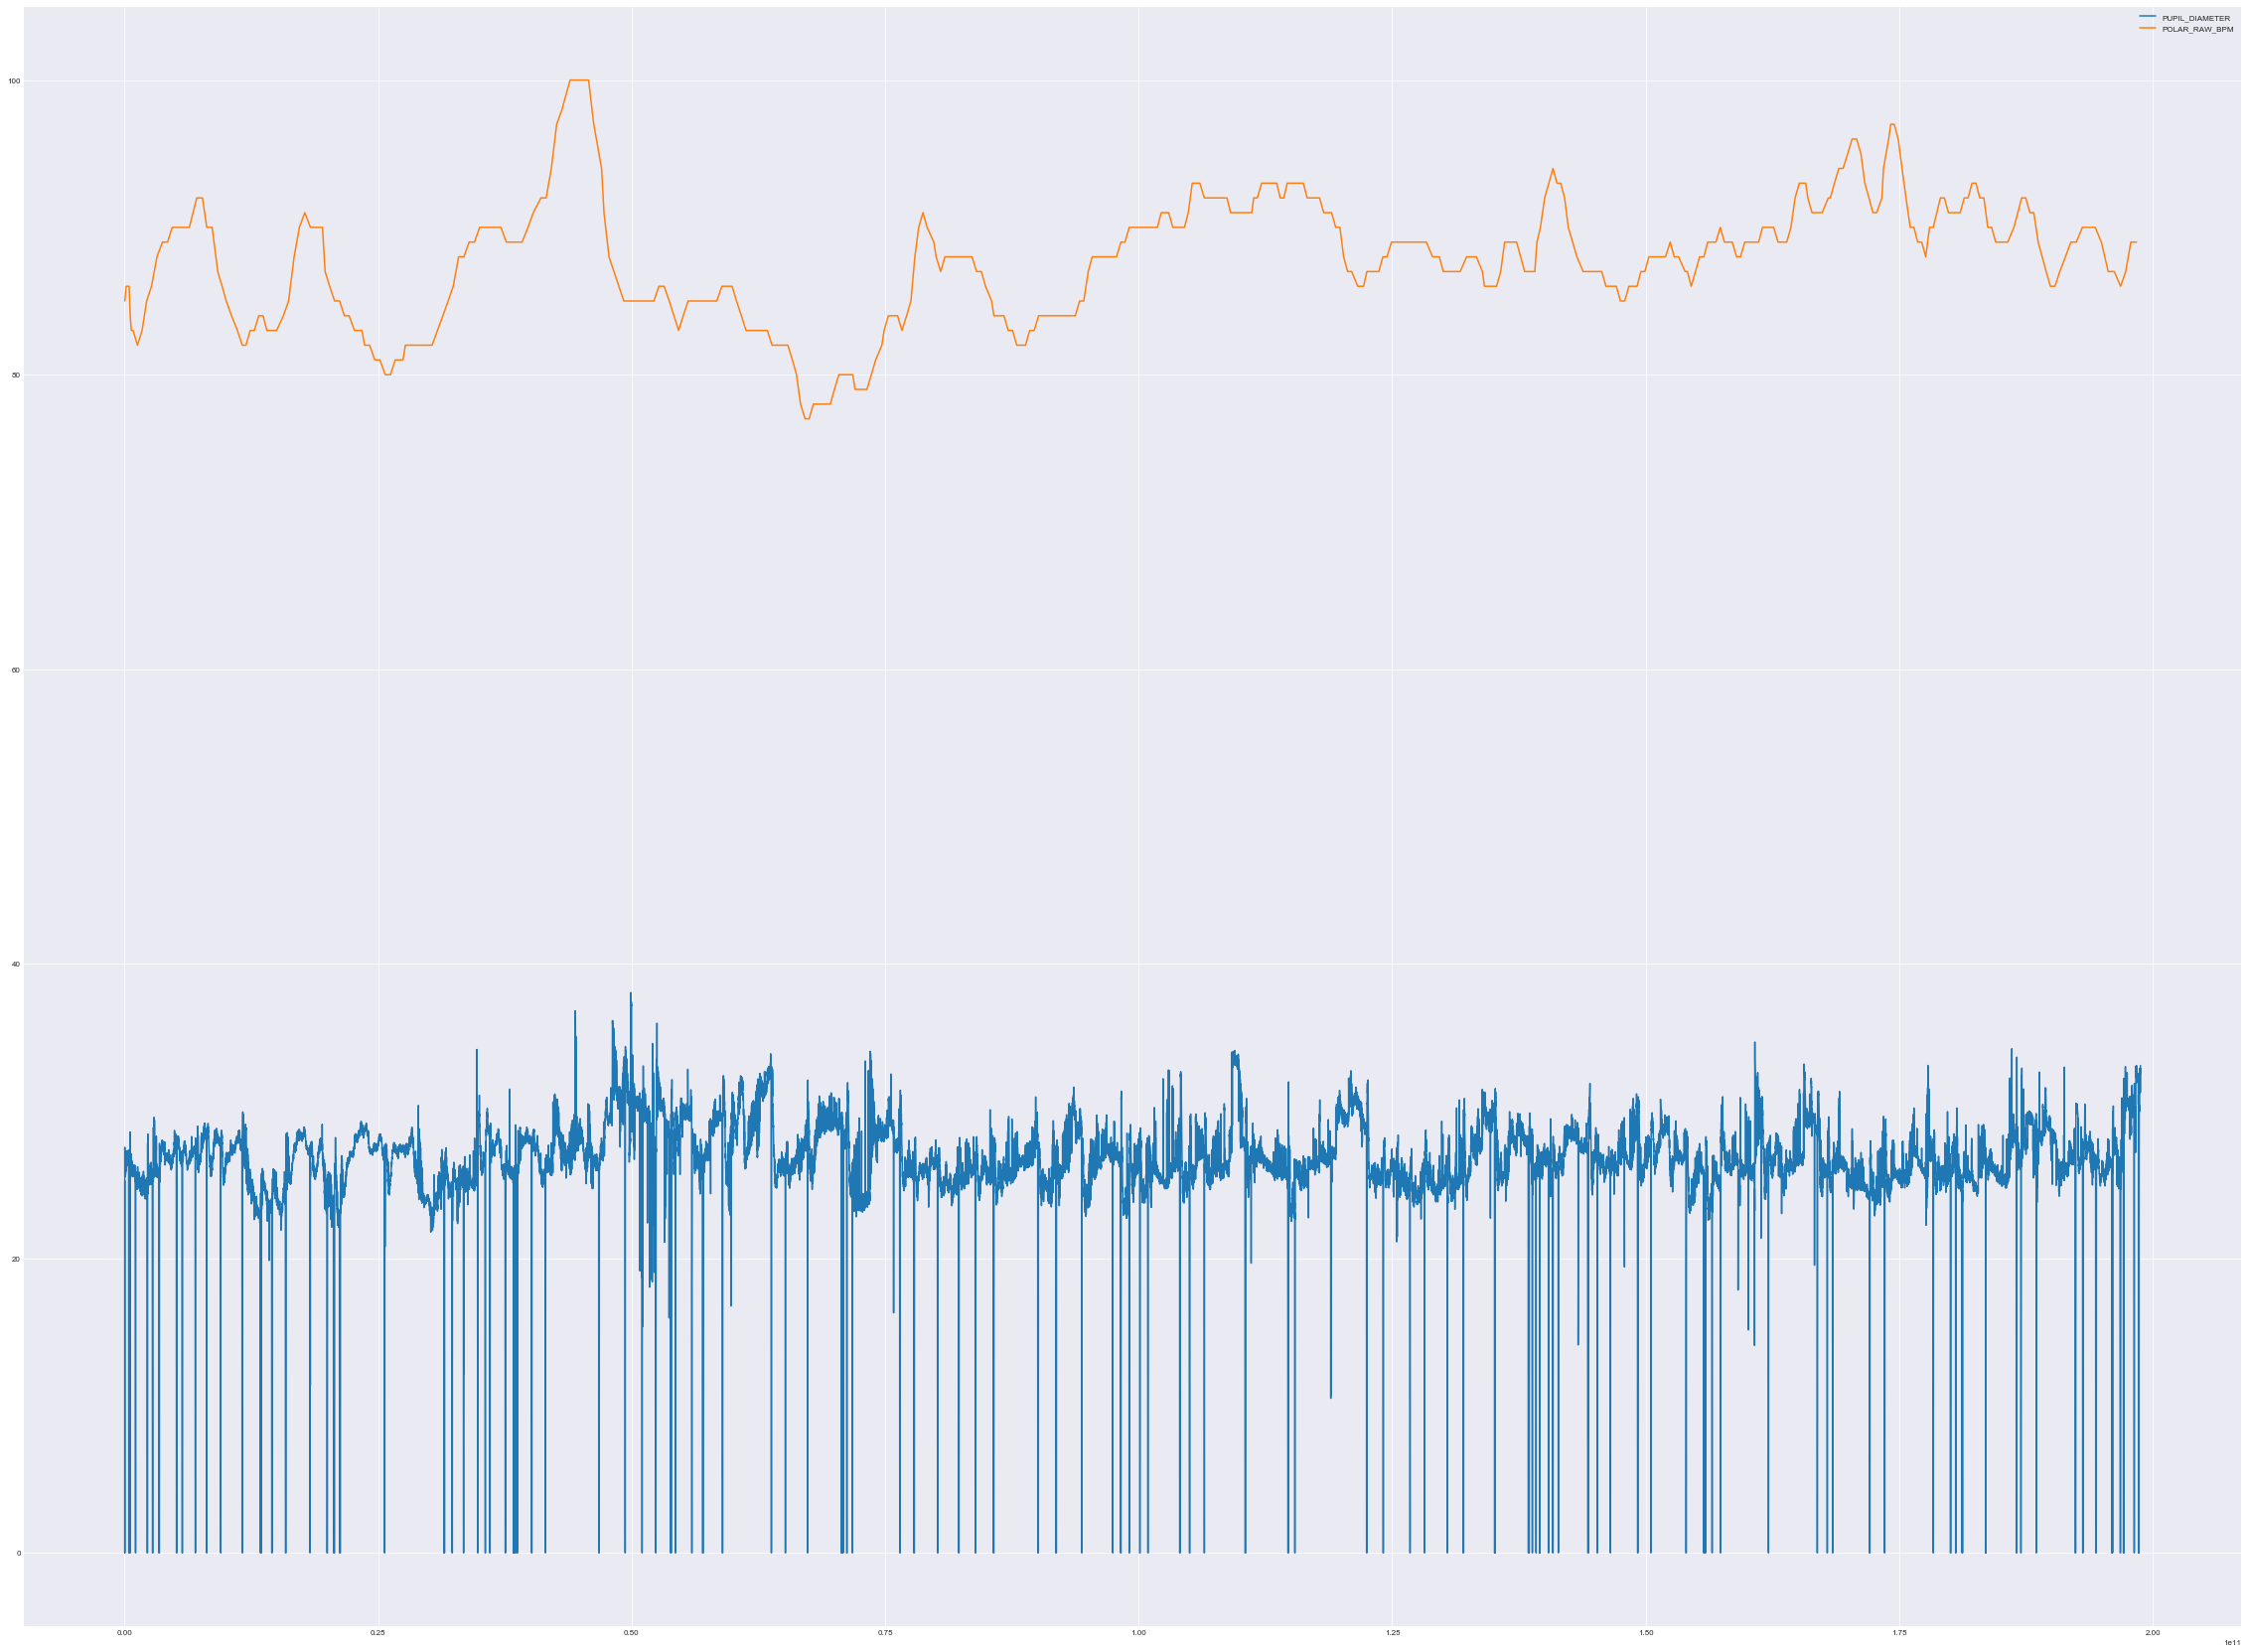

In [394]:
plt.plot(df_pupil['rosbagTimestamp'],df_pupil['diameter'], label="PUPIL_DIAMETER")
plt.plot(polar_t_bpm_rr['rosbagTimestamp'],polar_t_bpm_rr['bpm'], label="POLAR_RAW_BPM")
#DIRTY TESTING
#plt.plot(polar_t_bpm_rr['rosbagTimestamp'][0:435],rri_interpol_bio_clean_ms, label="bio_ms")
plt.legend()

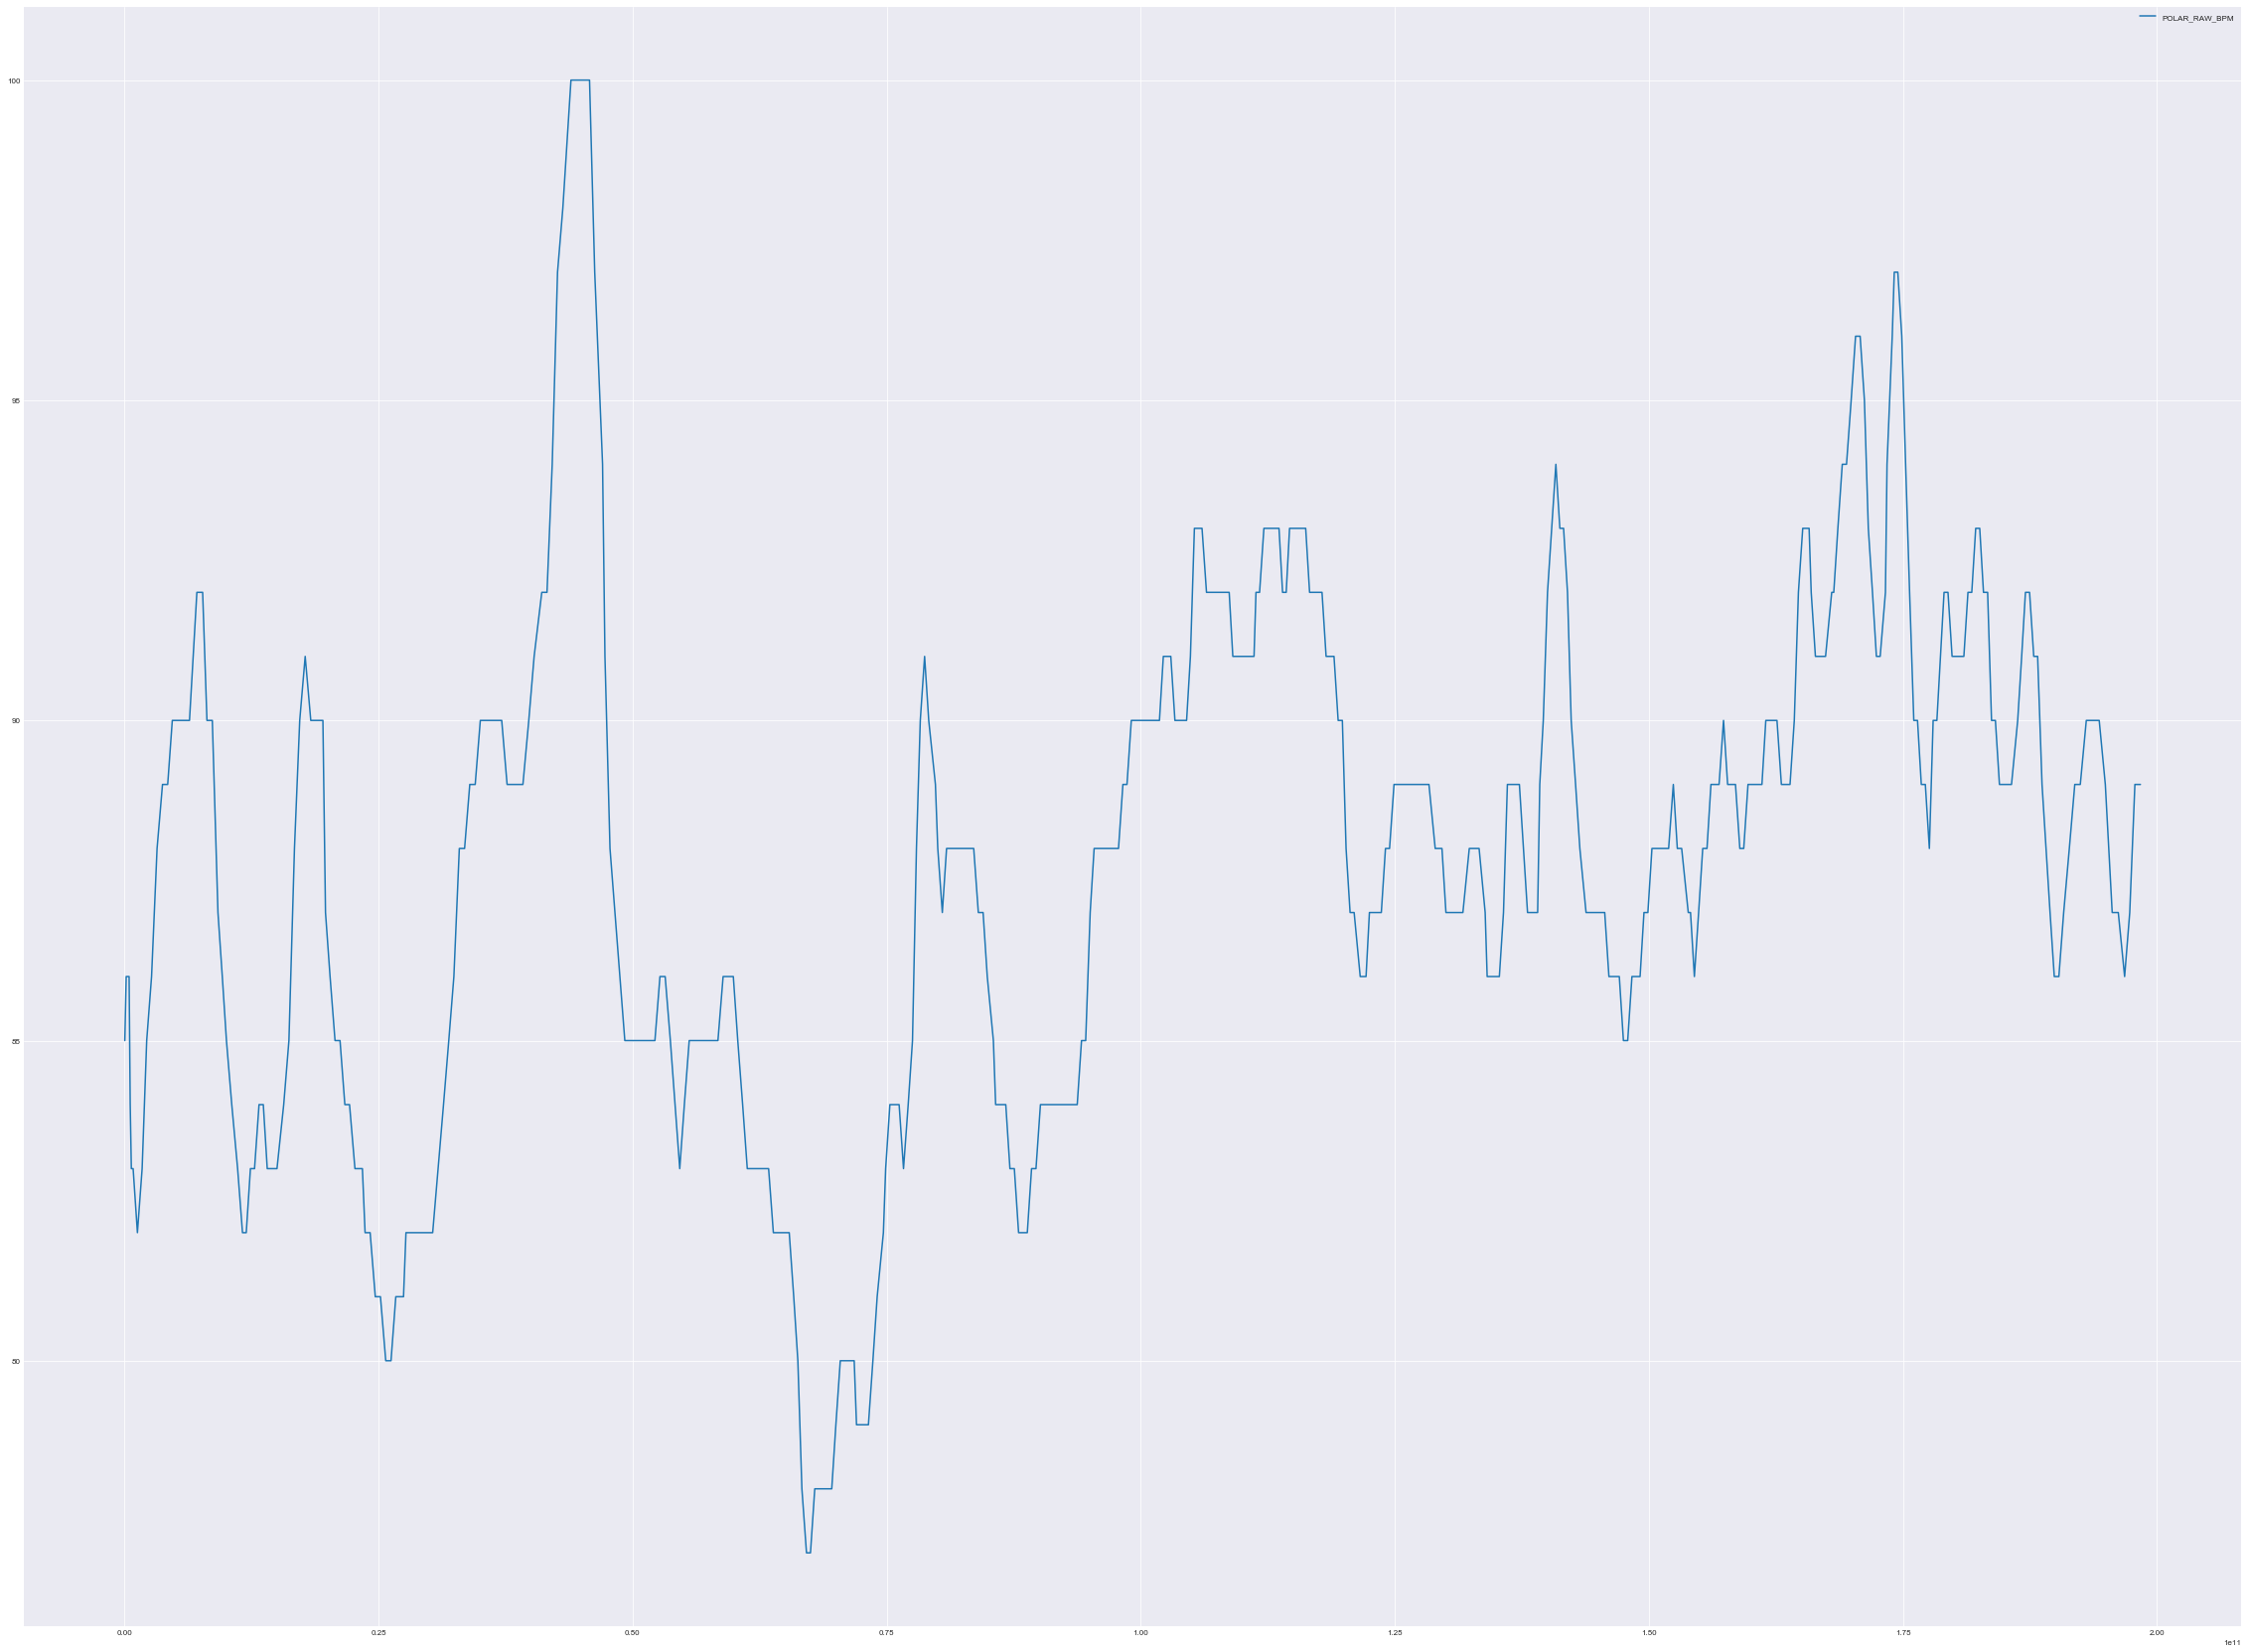

In [395]:
plt.plot(polar_t_bpm_rr['rosbagTimestamp'],polar_t_bpm_rr['bpm'], label="POLAR_RAW_BPM")
plt.legend()

In [396]:
polar_t_bpm_rr.keys

<bound method NDFrame.keys of                  t  bpm   rr  rosbagTimestamp
0    "15_07_51_723   85  689         36000000
1    "15_07_52_712   86  685        172000000
2    "15_07_53_702   86  700        334000000
3    "15_07_54_692   86  731        457000000
4    "15_07_55_682   84  777        566000000
..             ...  ...  ...              ...
452  "15_15_23_664   87  740     196198000000
453  "15_15_24_654   86  728     196821000000
454  "15_15_25_644   87  699     197325000000
455  "15_15_26_634   89  661     197832000000
456  "15_15_27_624   89  651     198380000000

[457 rows x 4 columns]>

# Shifting/Rolling Window Correlation

In [397]:
#outdated 
#pd.rolling_corr(polar_t_bpm_rr['rr'], polar_t_bpm_rr['rr'], 12)

In [398]:
df_corr=pd.DataFrame(polar_t_bpm_rr['rr'][0:435].astype(int))
df_corr['bio_rr']=pd.DataFrame(rri_interpol_bio_clean)

### Set window size here!!!

In [399]:
windowsize = 30
c = df_corr["rr"].rolling(windowsize).corr(df_corr['bio_rr'])

In [400]:
c.tail()

430    0.622081
431    0.589938
432    0.558997
433    0.504942
434    0.483858
dtype: float64

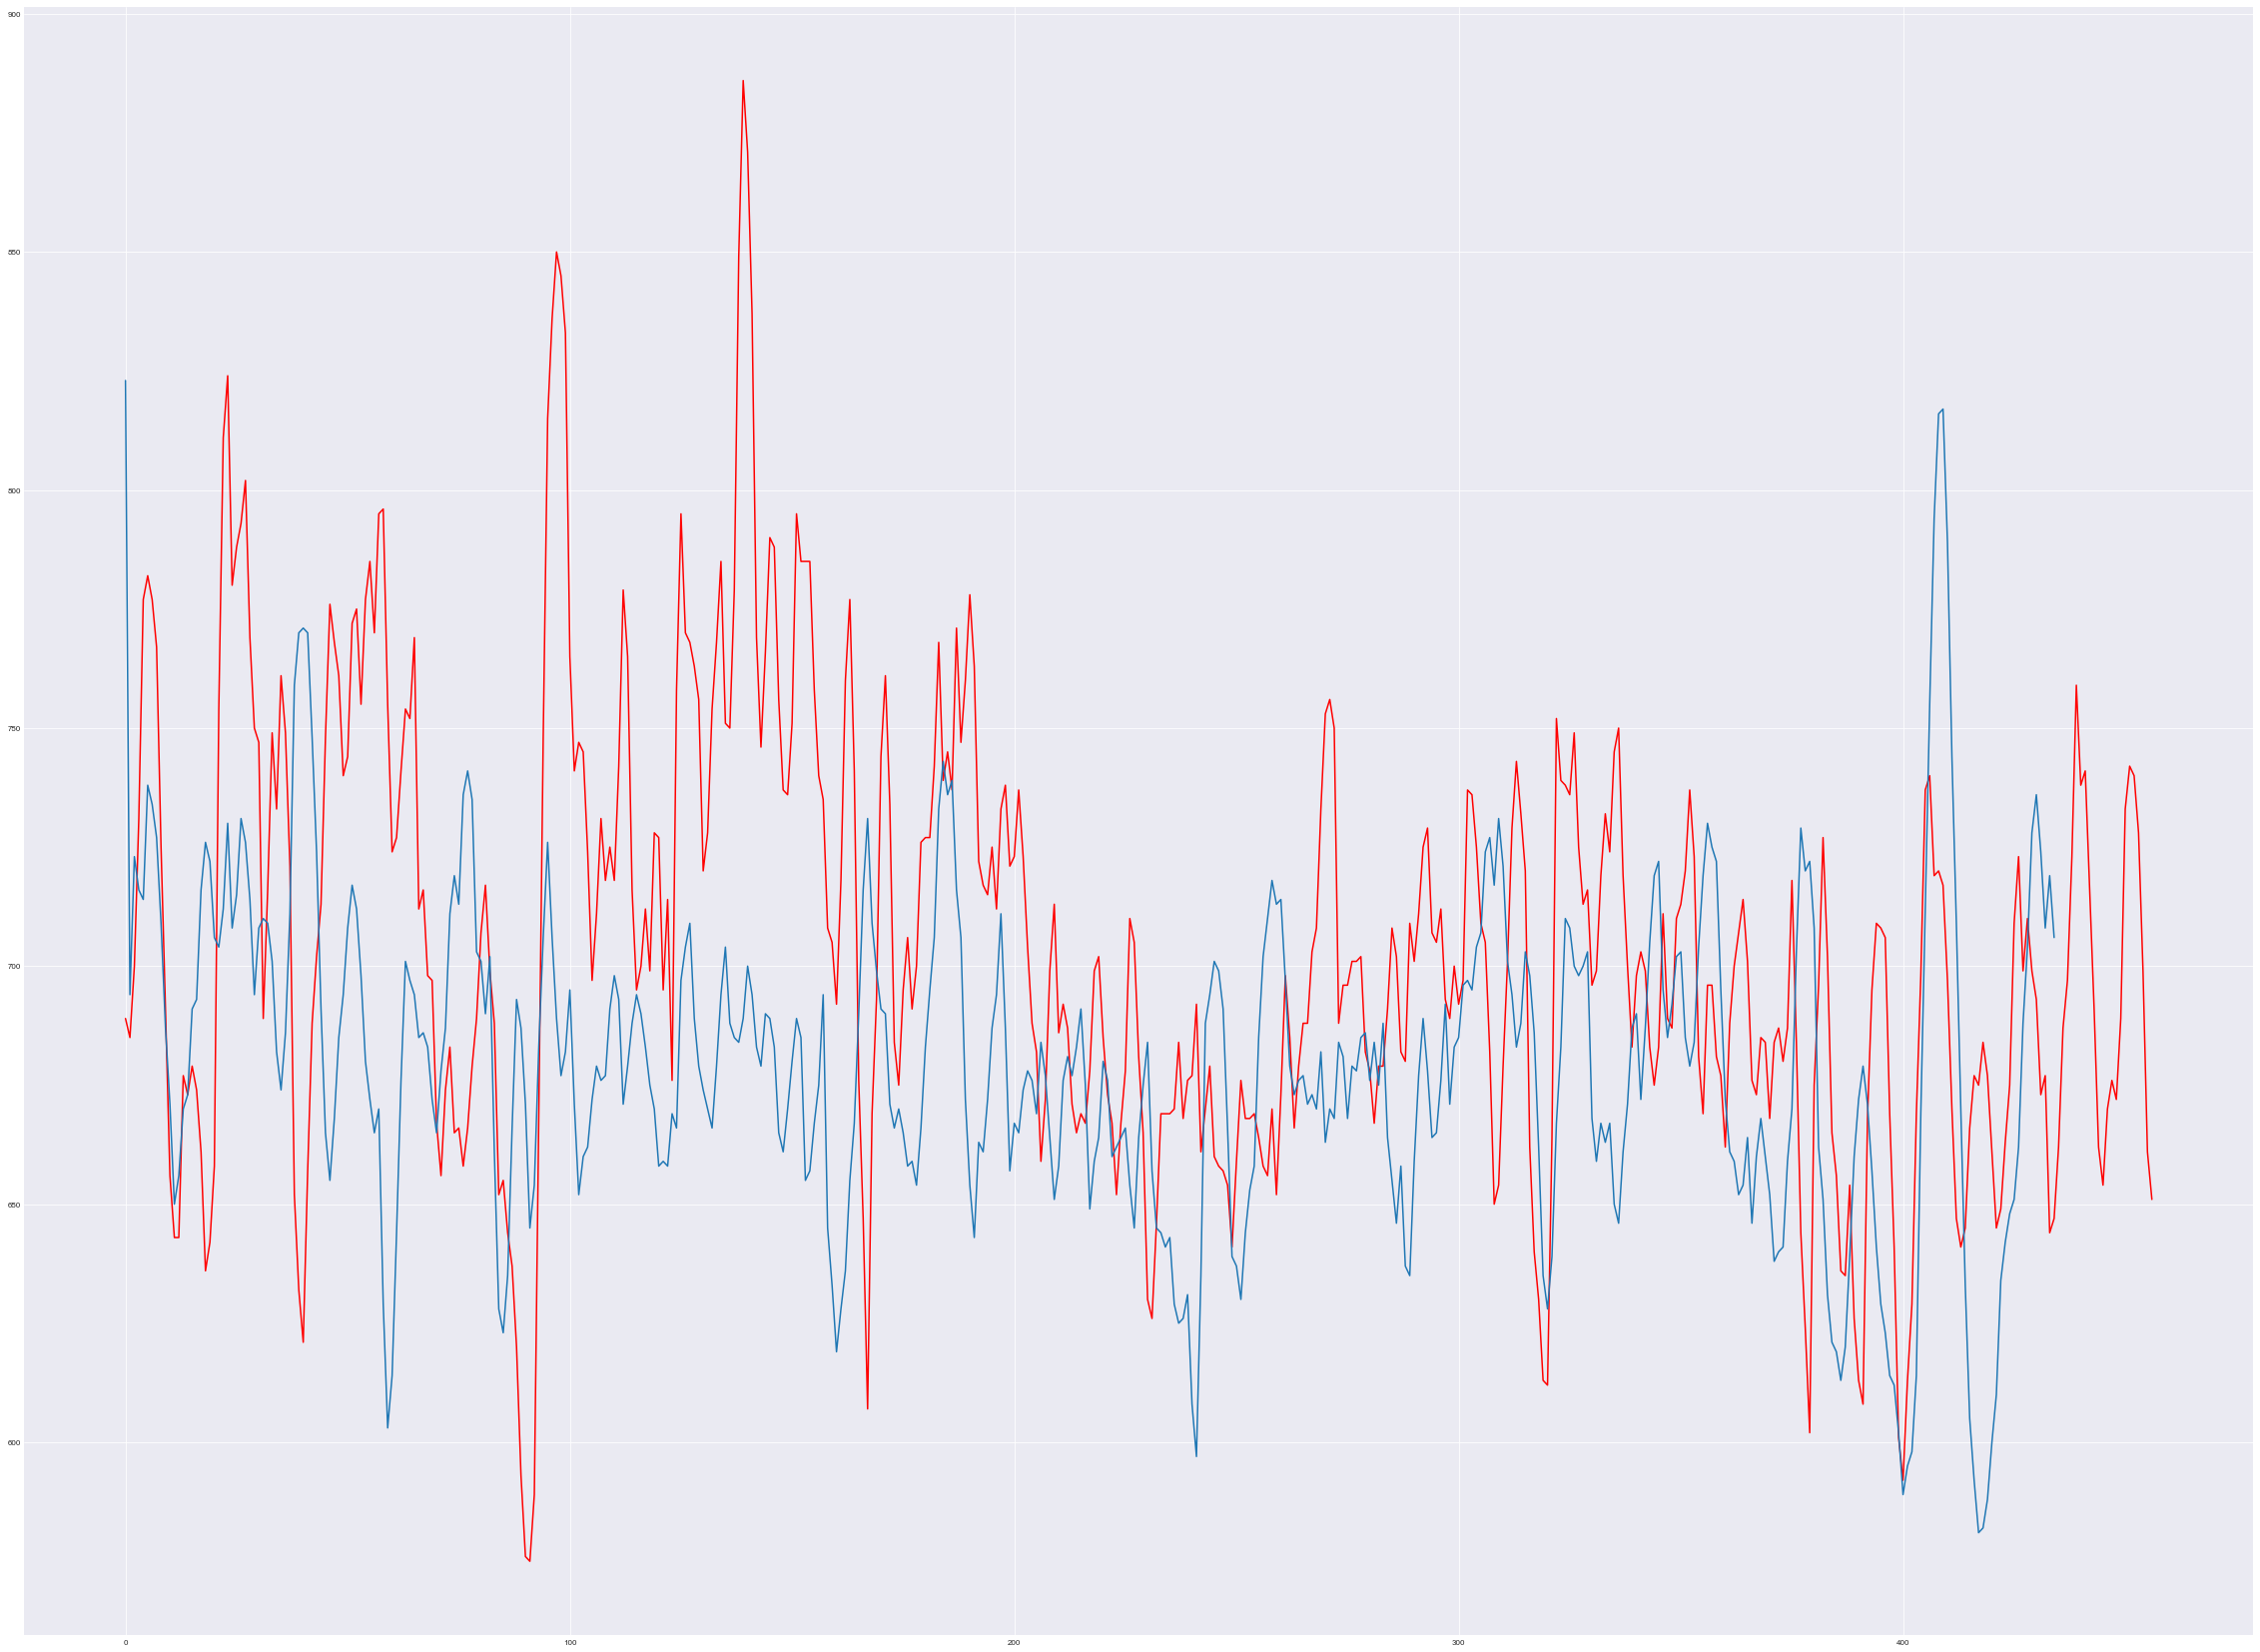

In [401]:
plt.plot(rri, label="POLAR RRI", color="red")
plt.plot(rri_interpol_bio_clean, label = "Biopac Cleaned")

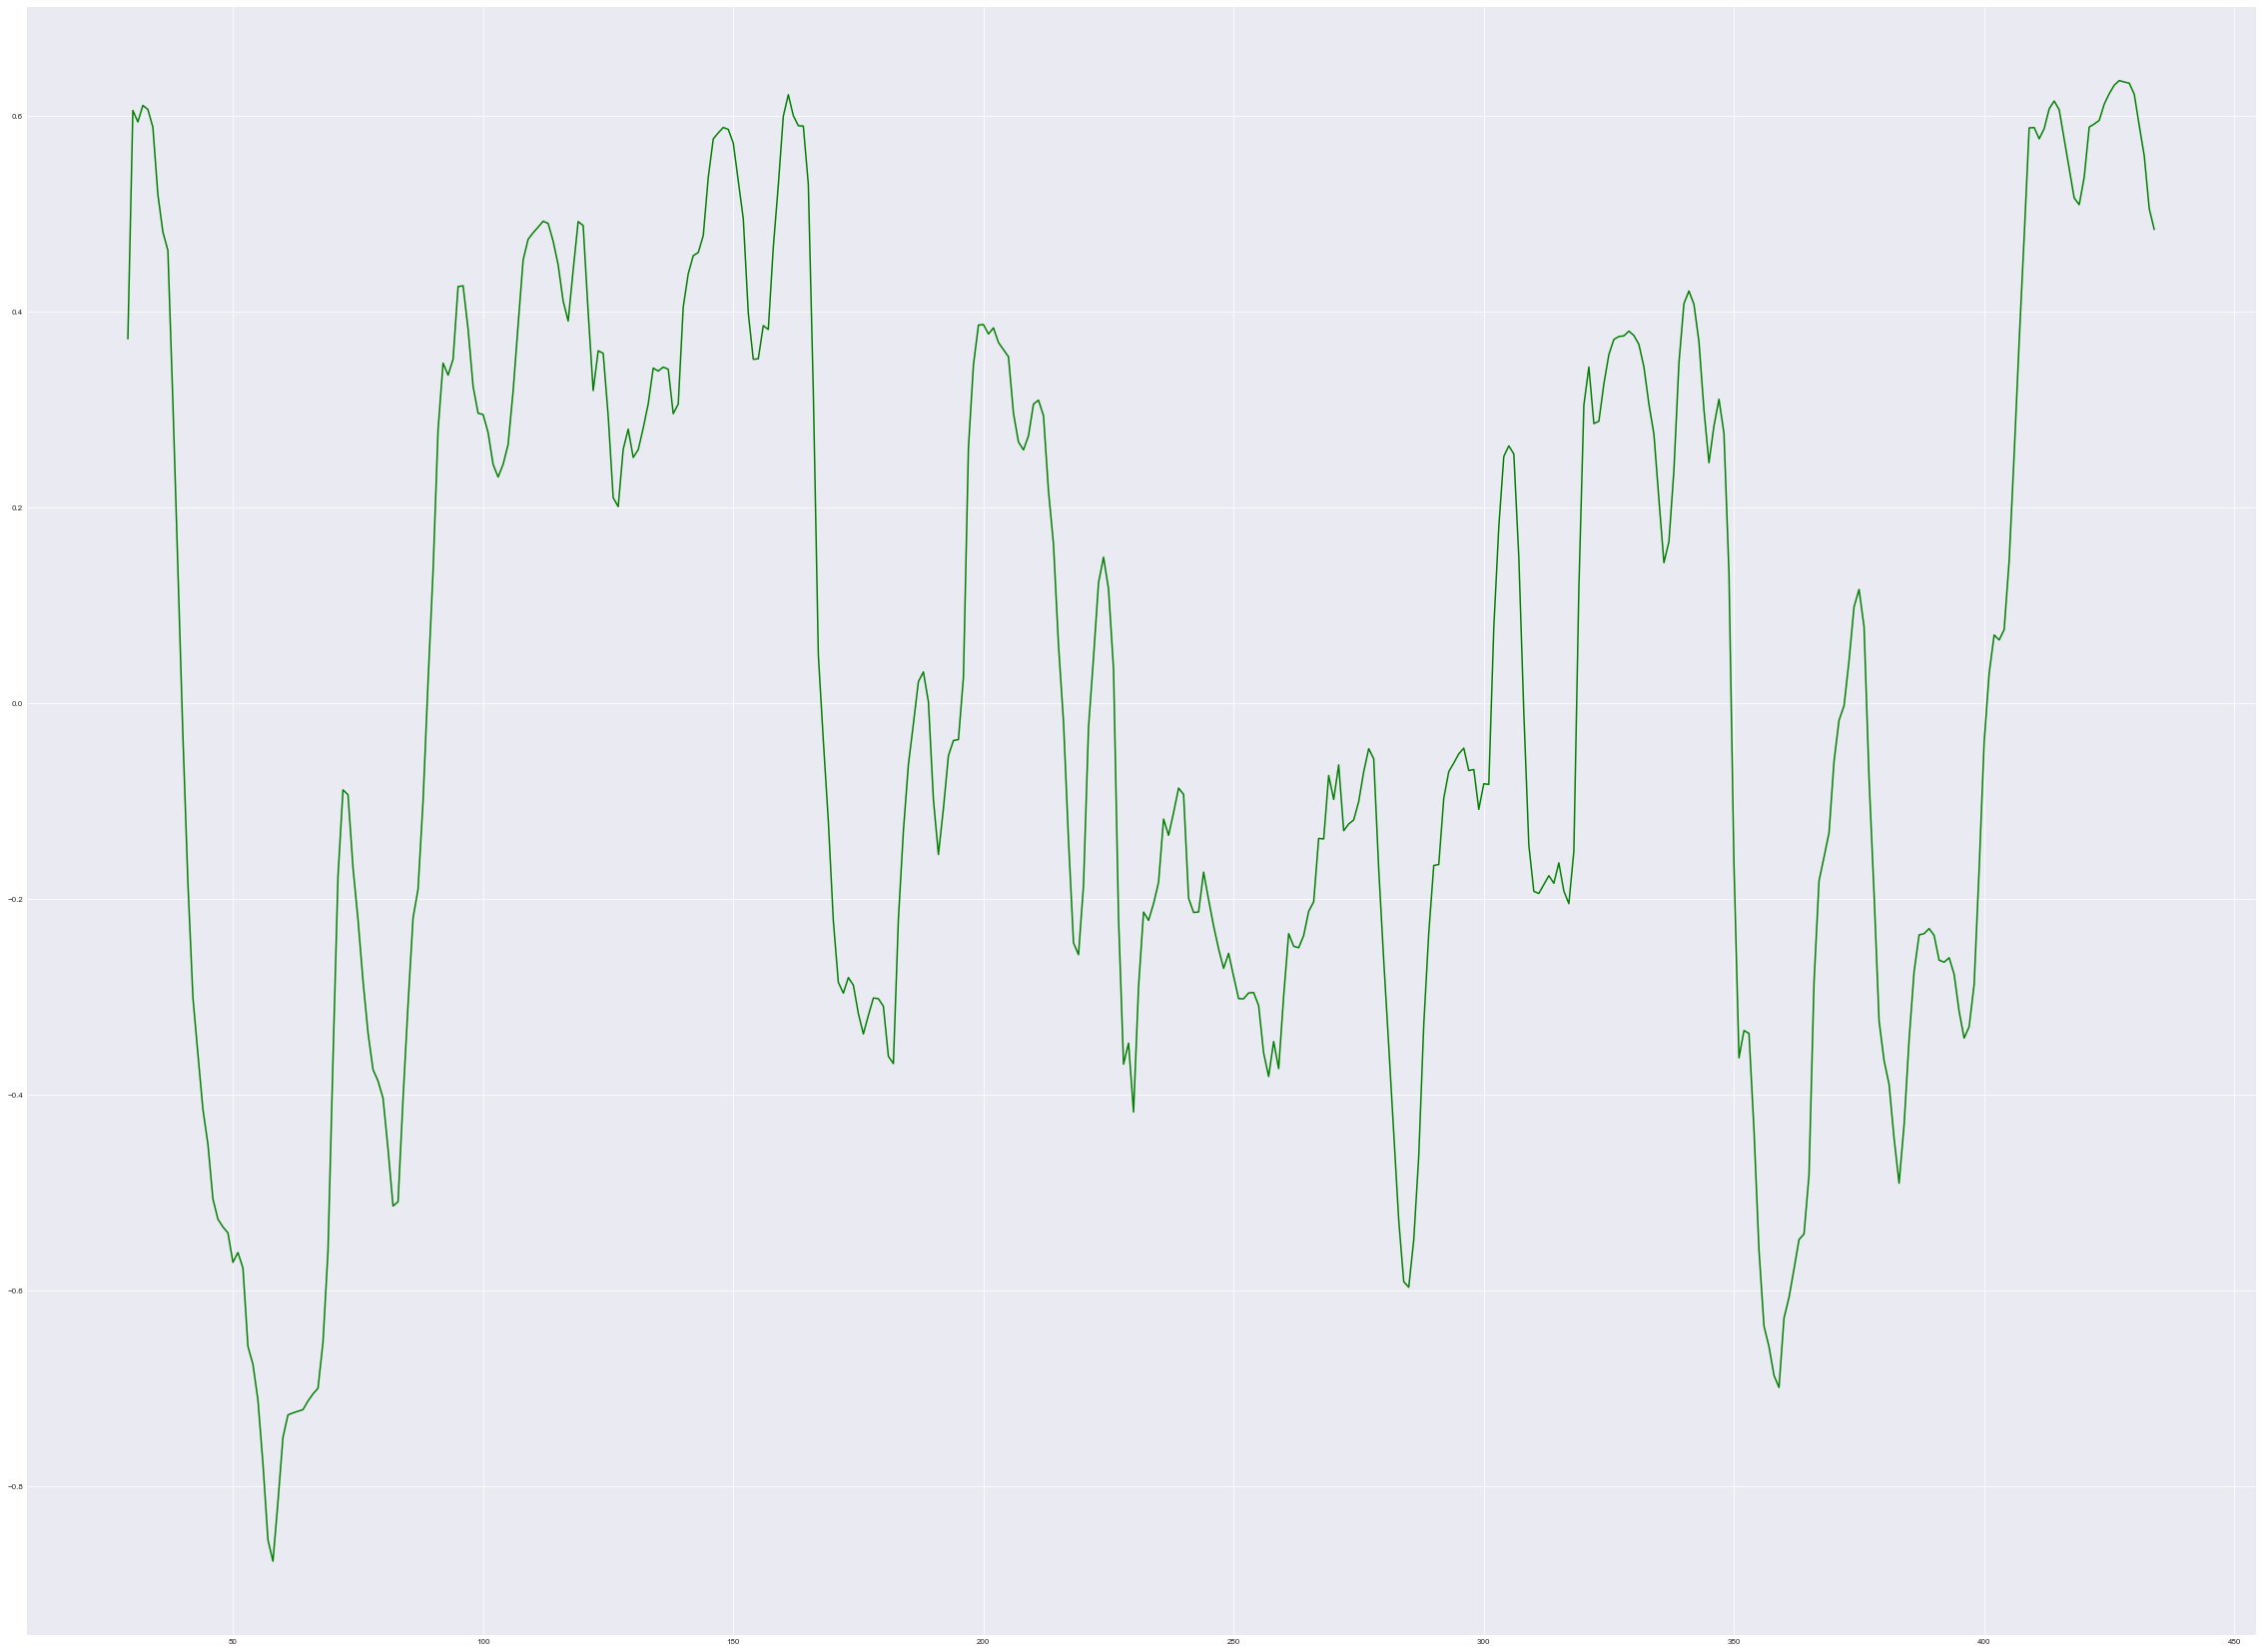

In [402]:
plt.plot(c, label = "CORR WINDOWED", color="green")

In [403]:
c.sum()

6.0880392153293865

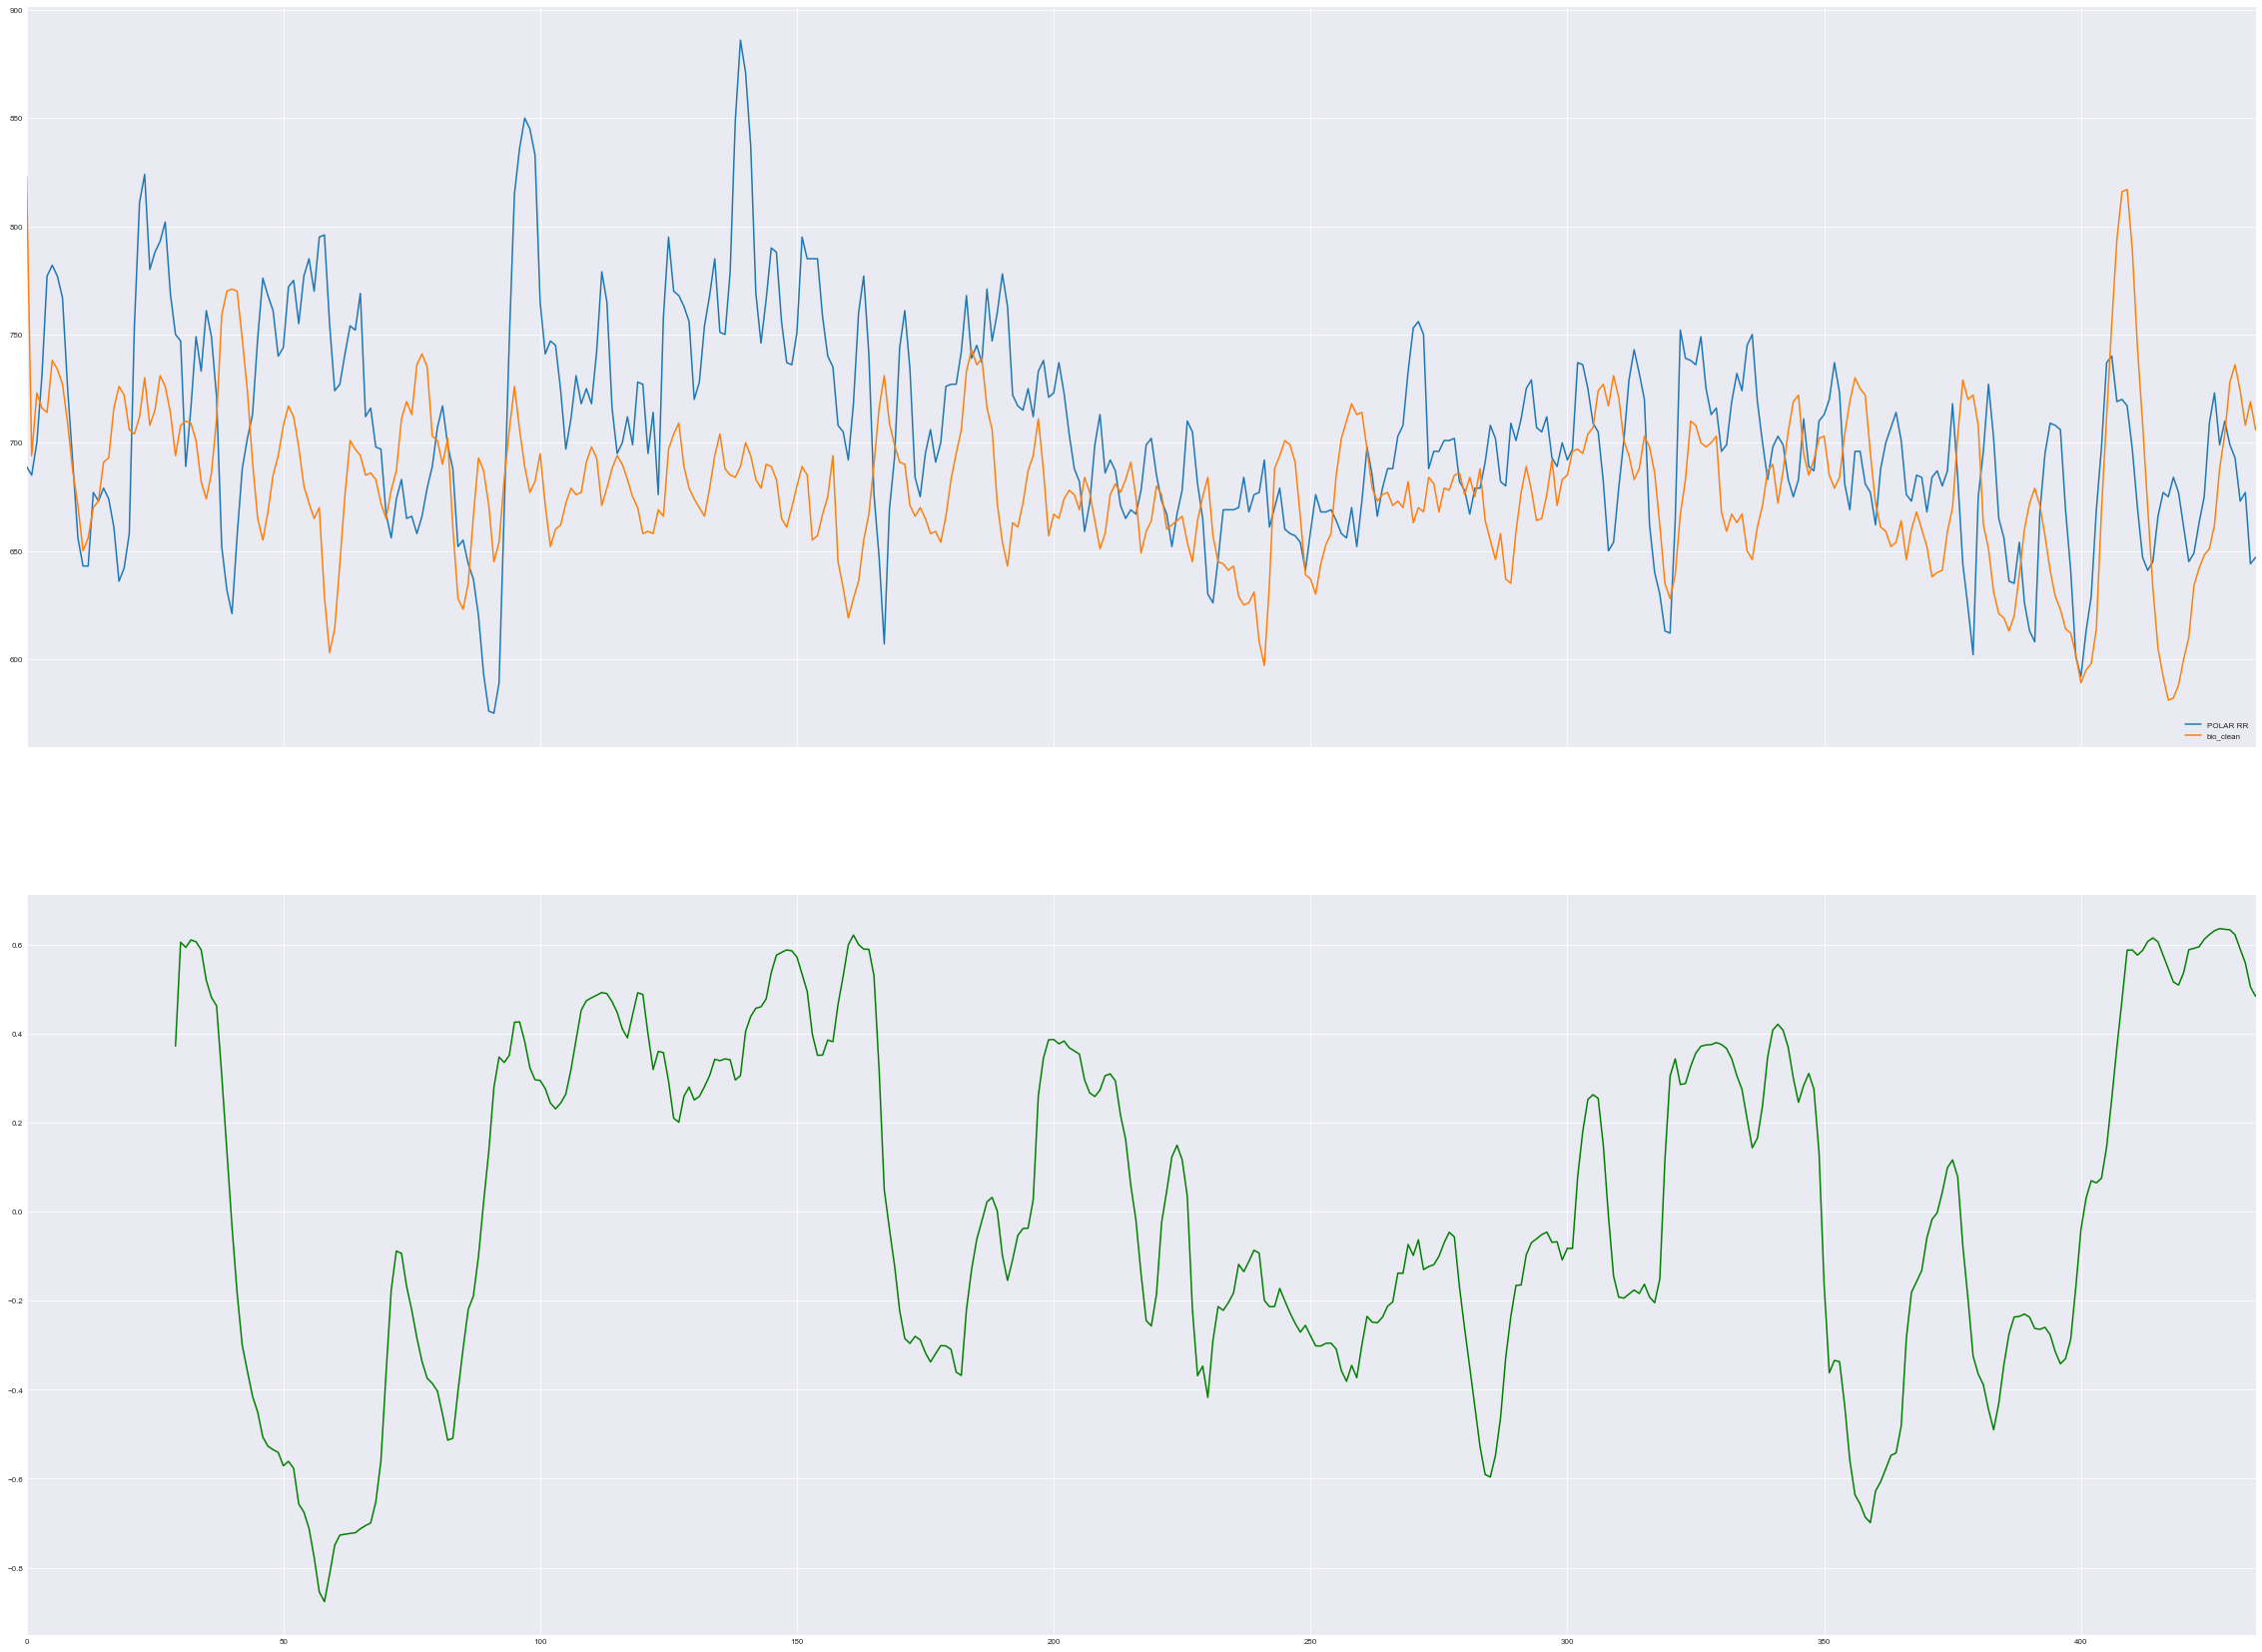

In [414]:
fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
#plt.plot(rri, label="POLAR RRI", color="red")
#plt.plot(rri_interpol_bio_clean, label = "Biopac Cleaned")
dat = pd.DataFrame(rri_interpol_bio_clean, columns = ['bio_clean'])

polar_t_bpm_rr['rr'][0:435].plot(ax=ax1, label="POLAR RR")
dat.plot(ax=ax1, label="Biopac RR")
ax1.legend(loc=4)

c.plot(ax=ax2, color='green')

plt.show()

In [427]:
size(df_pupil['diameter'])

36817

In [432]:
df_pupil['rosbagTimestamp']

0            36000000
1            36000000
2            36000000
3            36000000
4            36000000
             ...     
36812    198740000000
36813    198745000000
36814    198755000000
36815    198765000000
36816    198779000000
Name: rosbagTimestamp, Length: 36817, dtype: int64

In [429]:
polar_t_bpm_rr['rosbagTimestamp']

0          36000000
1         172000000
2         334000000
3         457000000
4         566000000
           ...     
452    196198000000
453    196821000000
454    197325000000
455    197832000000
456    198380000000
Name: rosbagTimestamp, Length: 457, dtype: int64

In [441]:
size(polar_t_bpm_rr['rosbagTimestamp'])

457

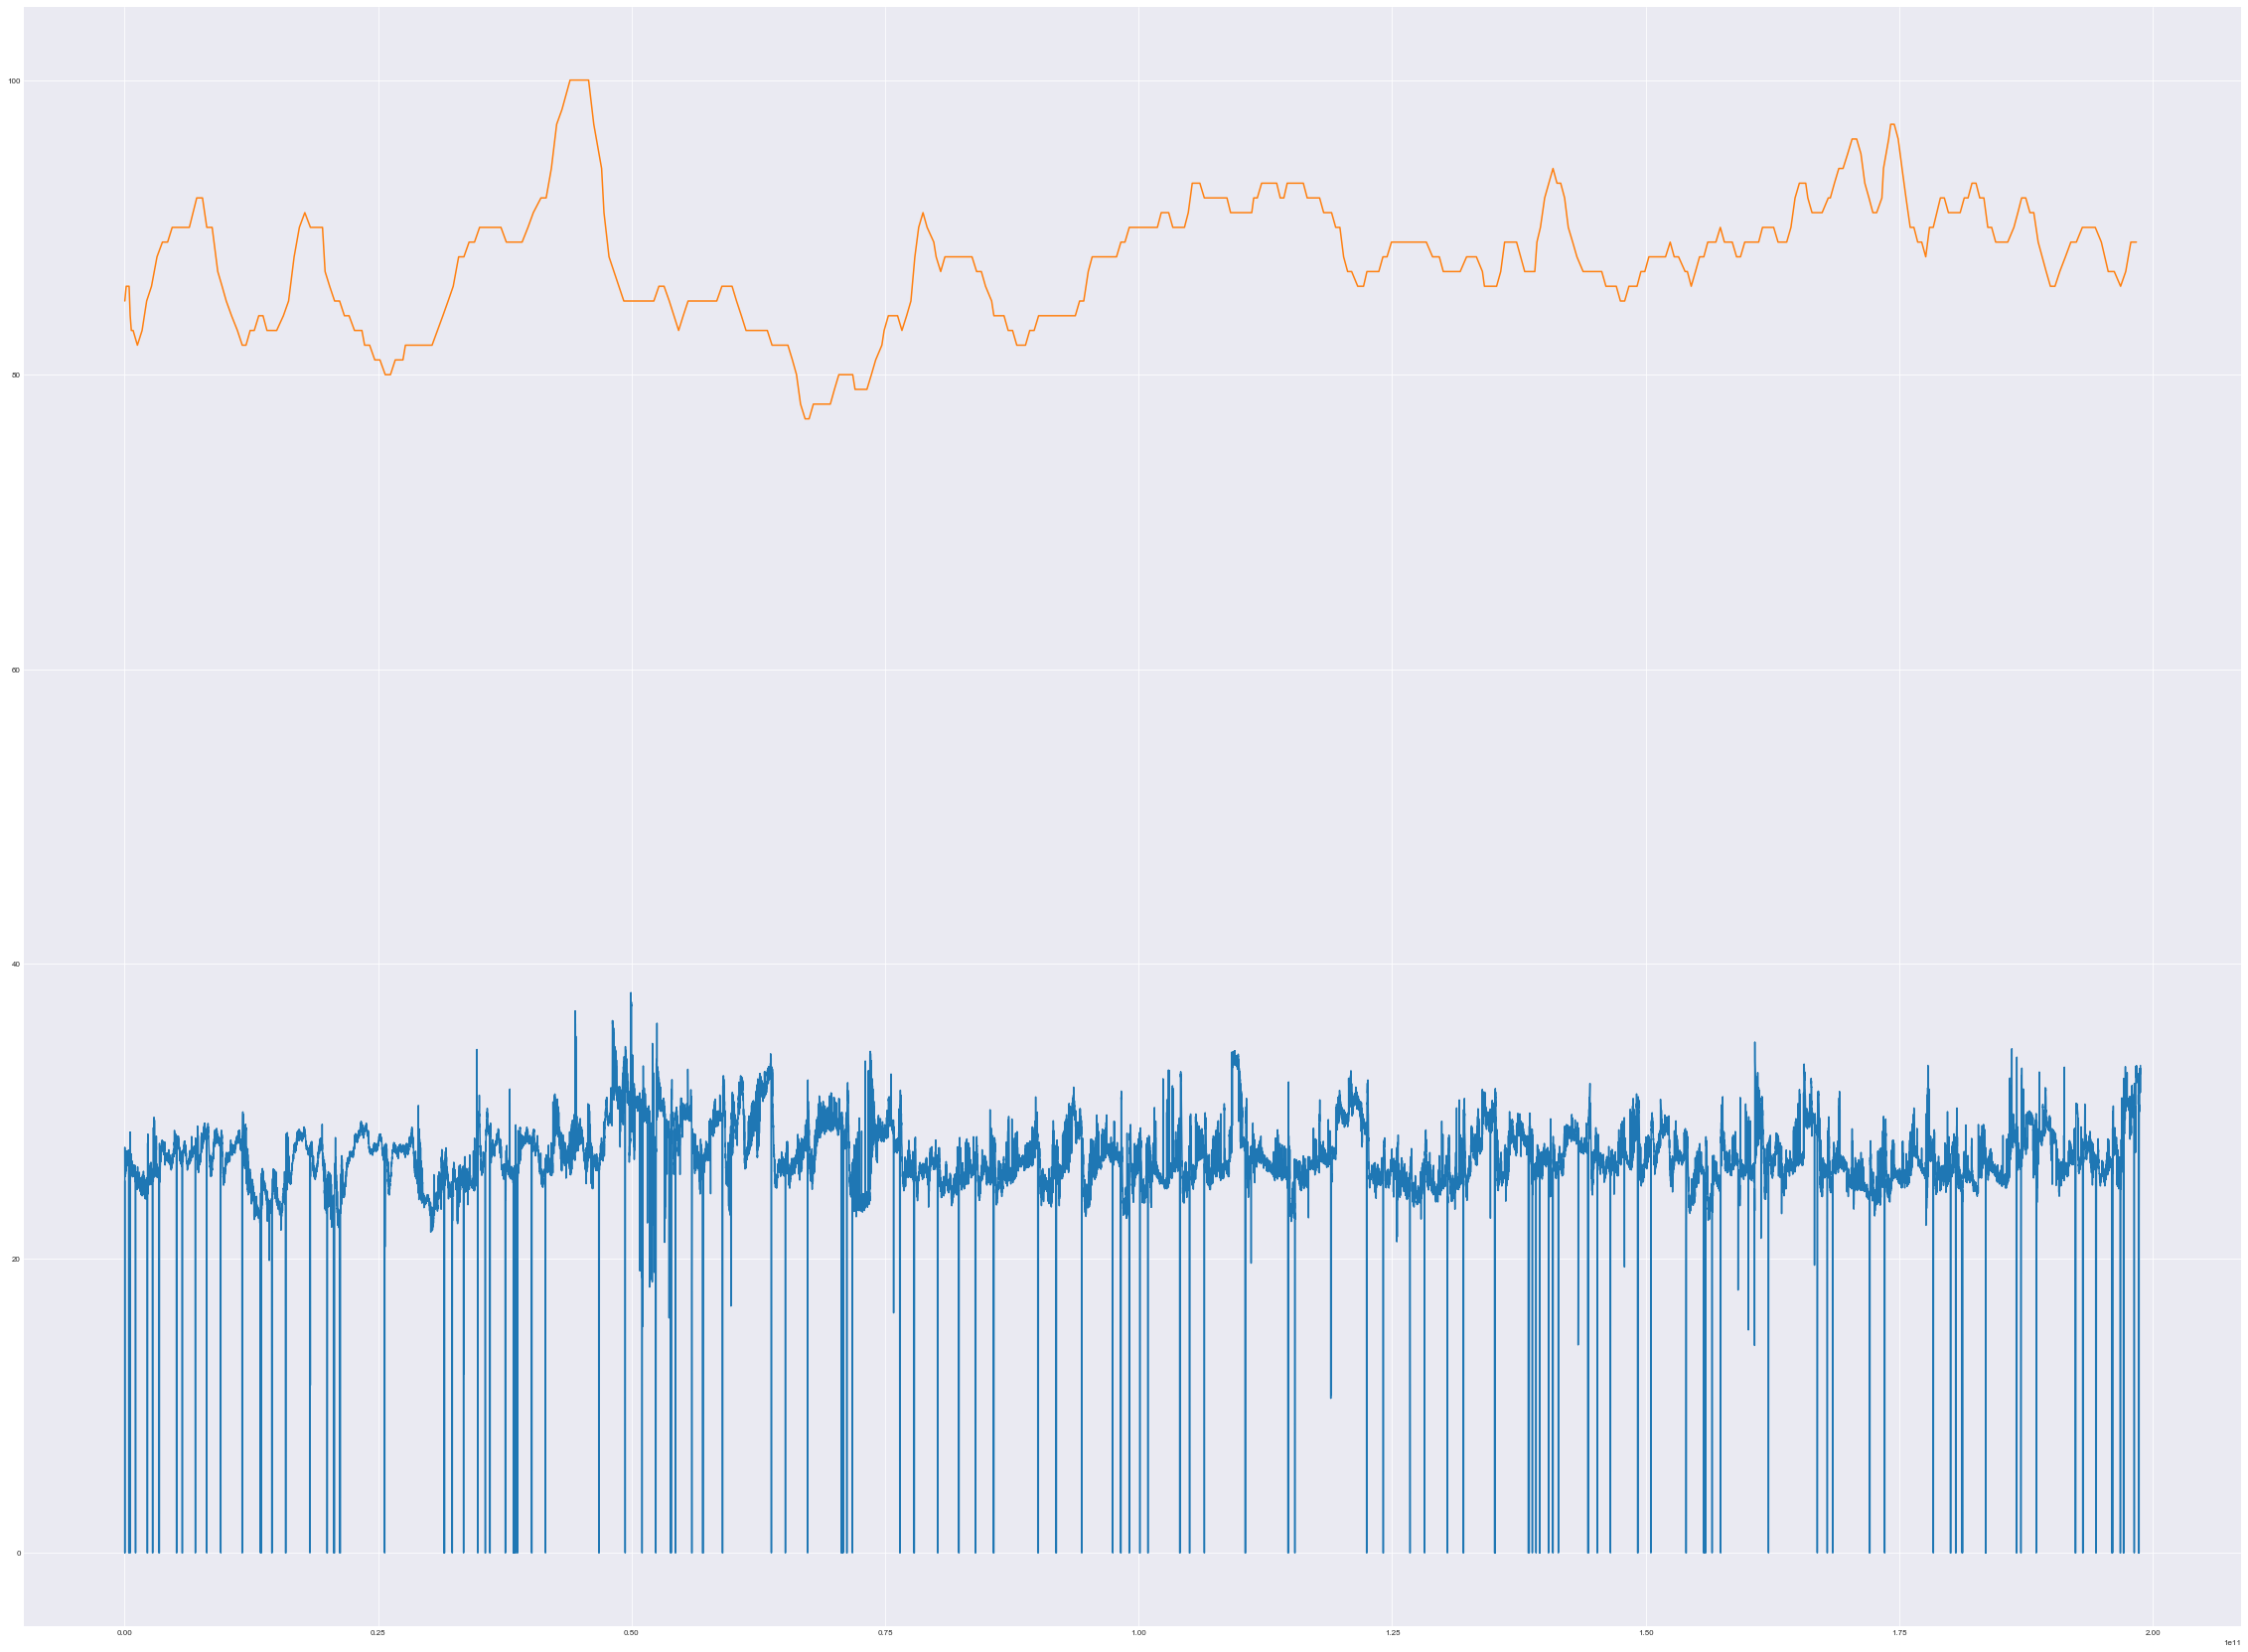

In [443]:

#windowsize = 30
c2 = polar_t_bpm_rr['rr'].rolling(windowsize).corr(df_pupil['diameter'])

plt.plot(df_pupil['rosbagTimestamp'],df_pupil['diameter'], label="PUPIL_DIAMETER")
plt.plot(polar_t_bpm_rr['rosbagTimestamp'],polar_t_bpm_rr['bpm'], label="POLAR_RAW_BPM")

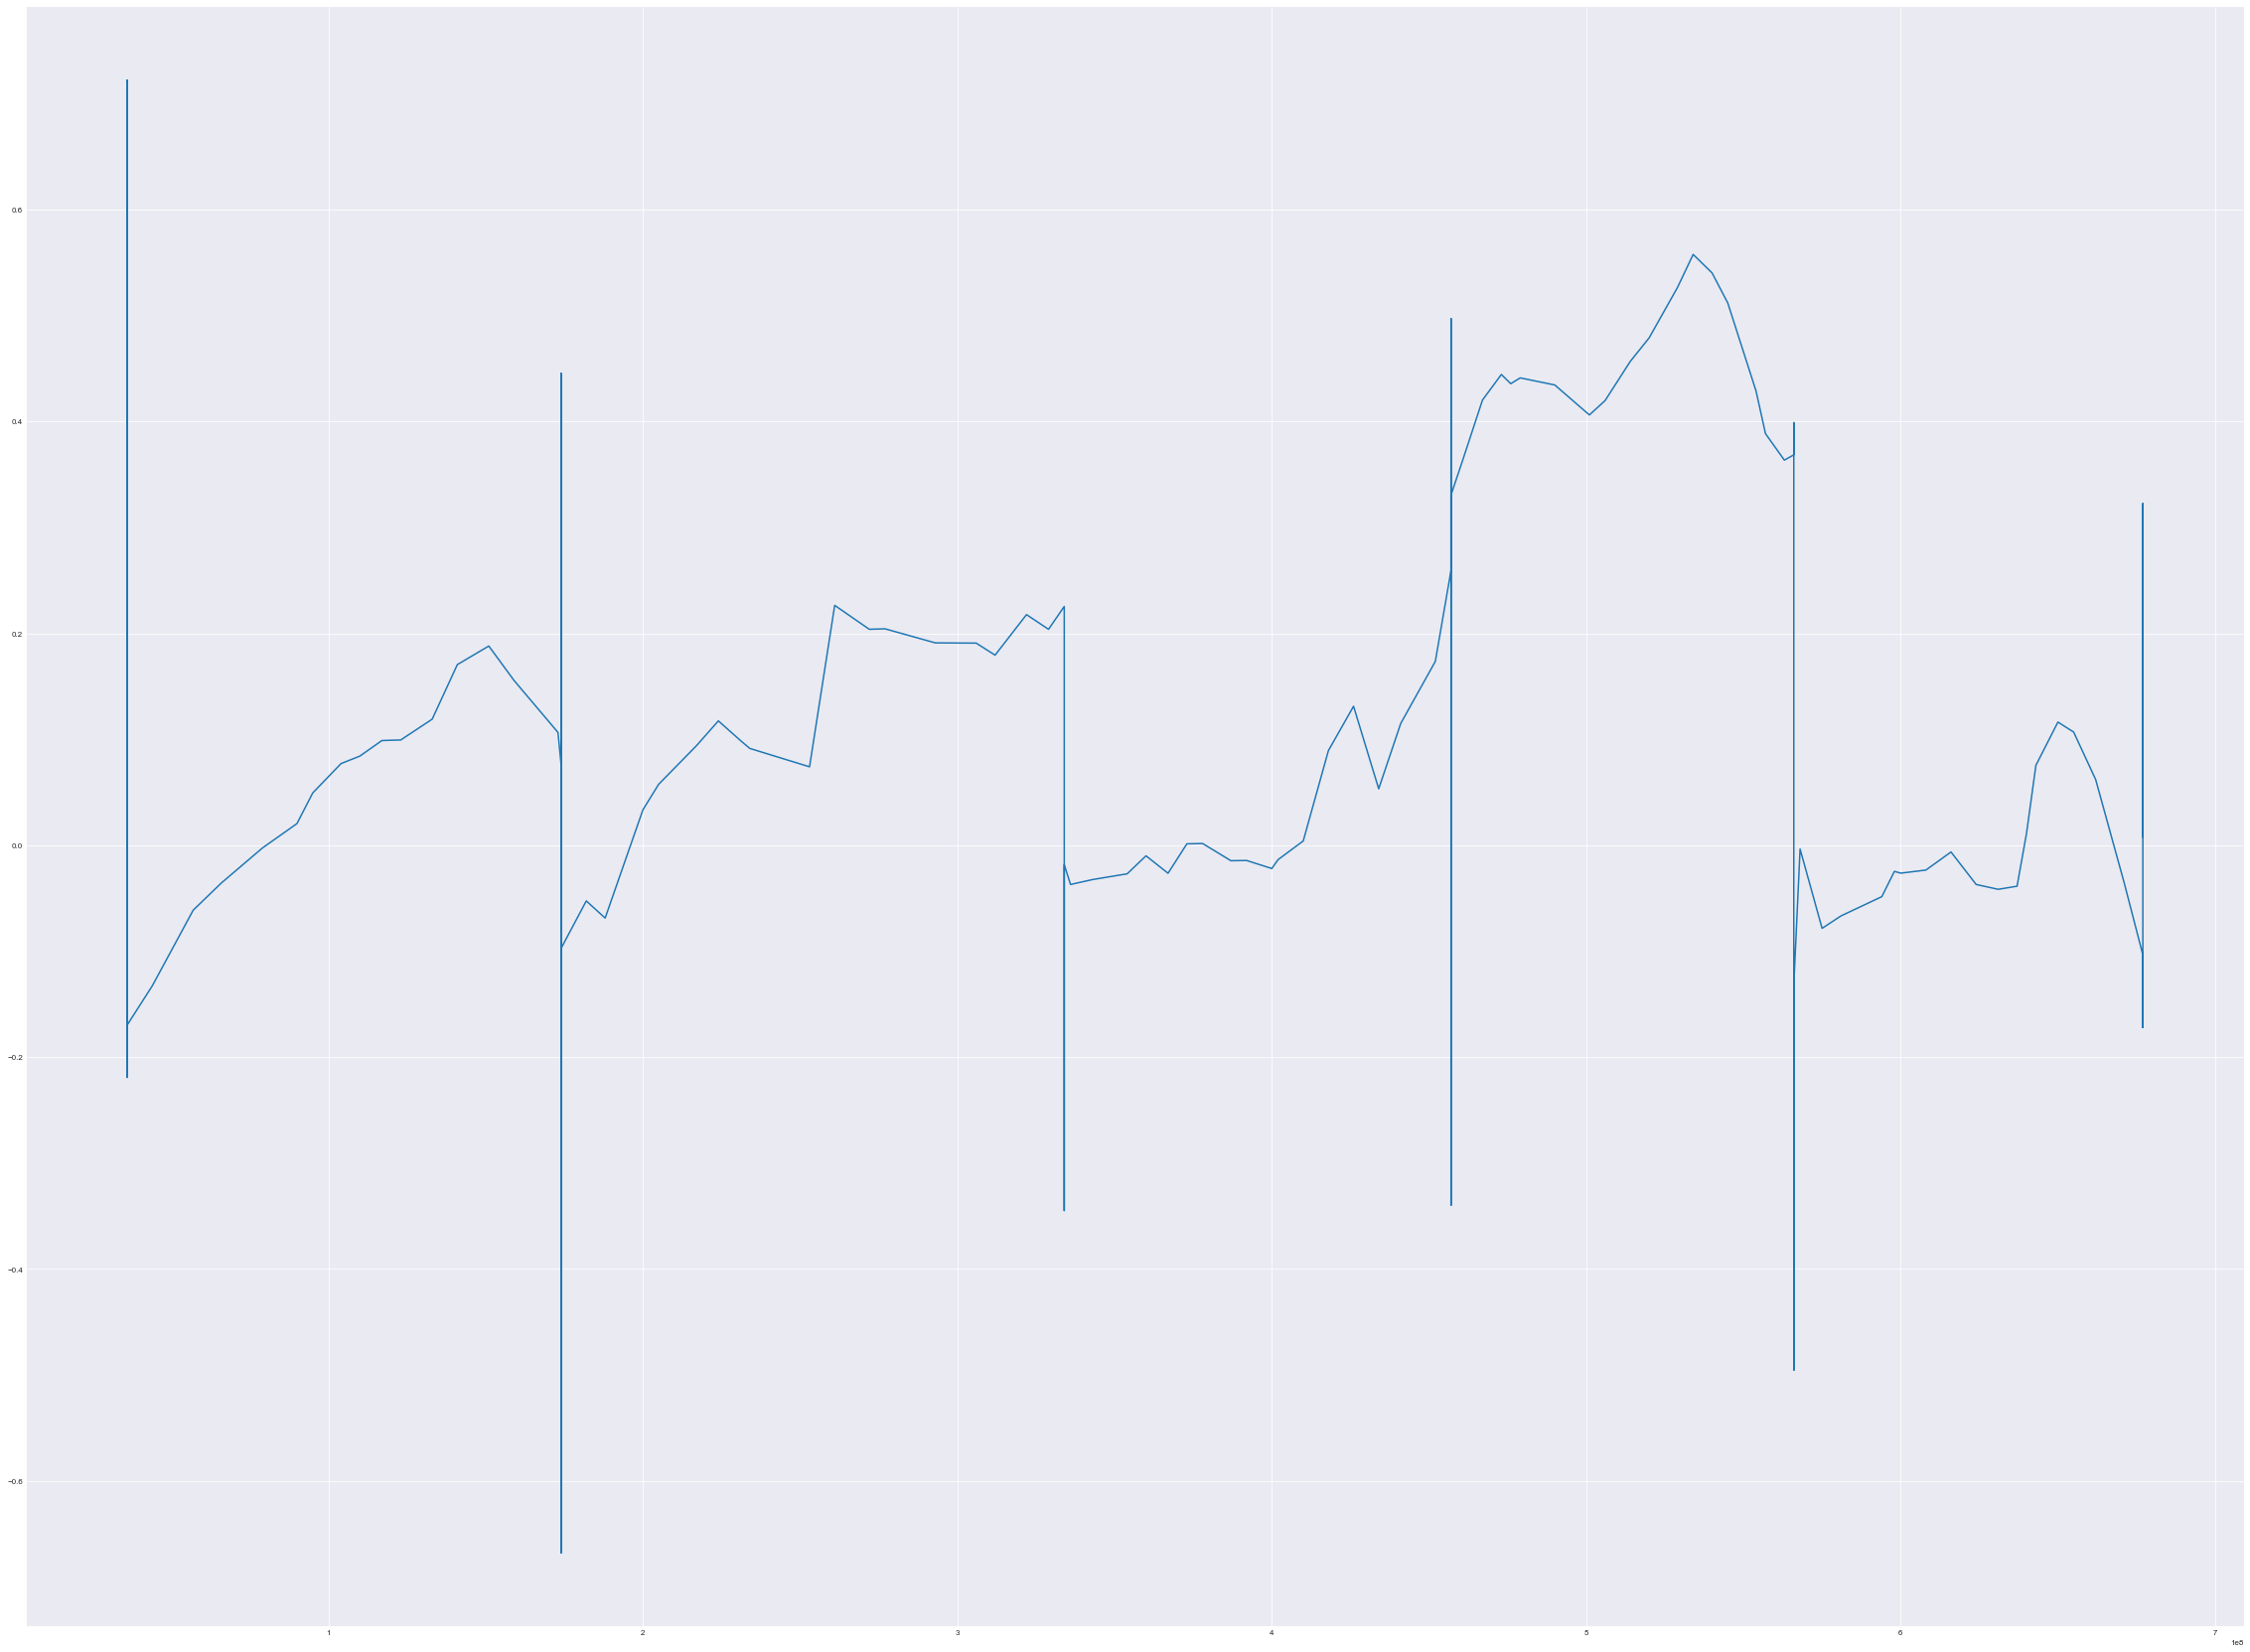

In [444]:
plt.plot(df_pupil['rosbagTimestamp'], c2, label="CORR")